In [1]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#import time
from multiprocessing import Pool, cpu_count
import emcee
import corner
from Corrfunc.theory.wp import wp
#import MCMC_data_file
from numpy.linalg import inv
#import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import MCMC_data_file, zehavi_data_file_19, guo_data_file, mock_data, mock_data_2
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from math import floor,ceil

In [2]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


In [47]:
#fname = "combo_param_mv_fit.h5"
#fname = "zehavi_smdpl_vmax_m21_1.h5"
#fname = "zehavi_smdpl_vmax_m20_noGW.h5"
fname1 = 'zehavi_smdpl_mvir_m20_noGW_tabcorr.h5'
fname2 = 'zehavi_smdpl_mvir_m20_noGW_tabcorr_2.h5'
param ='mvir_'

In [10]:
files = [fname1,fname2]

#files = [fname4,fname5]
s = []
log_prob_s = []
wp = []

for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=1000, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=1000, flat=False, thin=1))
    wp.append(reader.get_blobs(discard=1000))
    
print(np.shape(wp))
print(np.shape(s))
print(np.shape(log_prob_s))


(2,)
(2,)
(2,)


In [30]:
if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wp[i+1]))
            
    max_n = samples.iteration
    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    tau = reader.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = (tau * 100 < reader.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    old_tau = tau
    print(converged,tau)

else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]
dsamples = samples[:,:20,:][::50,:]
print(np.shape(log_prob_samples))


greater
(748000, 20)


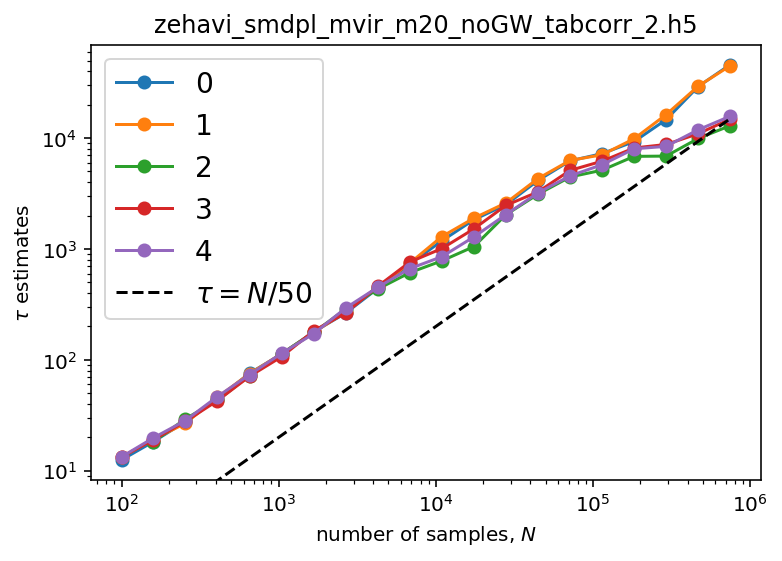

In [31]:
for j in range(5):
    chain = samples[:,:,j].T
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 20)).astype(int)
    gw2010 = np.empty(len(N))
    new = np.empty(len(N))
    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(chain[:, :n])
        new[i] = autocorr_new(chain[:, :n])

    # Plot the comparisons
    #plt.loglog(N, gw2010, "o-", label="G\&W 2010")
    plt.loglog(N, new, "o-", label=str(j))
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.title(fname)
plt.legend(fontsize=14);
plt.savefig('autocorr_'+fname[:-3]+'.png')


In [32]:
print("Min chi2:",round(-2*log_prob_samples.max(),3))
print("Min chi2 params:",list(np.array(samples[log_prob_samples==log_prob_samples.max()]))[0])
min_chi2_loc = np.where((-2*log_prob_samples.max())==-2*log_prob_samples)
#print(wp_samples[min_chi2_loc][-1])


Min chi2: 11.983
Min chi2 params: [11.92060851  0.18796737  1.13592057 10.18713426 13.28764472]


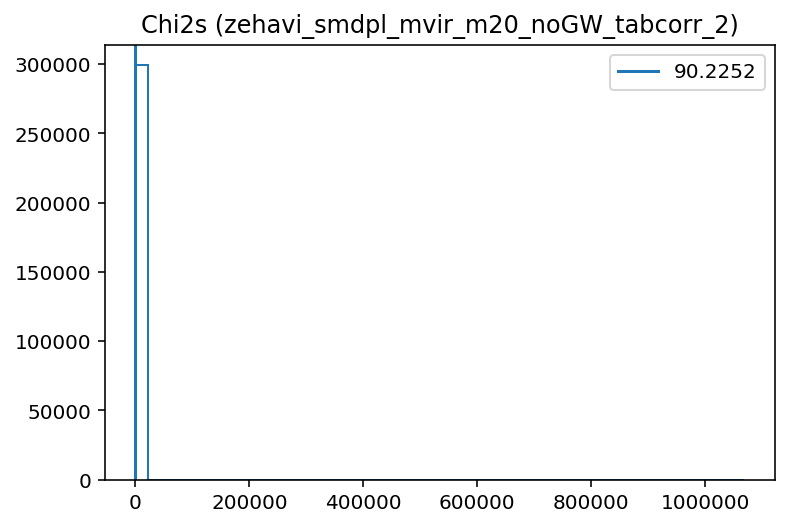

In [33]:
#plot chi2 distribution
sort_chi2 = np.sort(-2*log_prob_samples,axis=None)
plt.hist(sort_chi2[0::50],bins=50,histtype='step')
mean = np.mean(sort_chi2[0::50])
plt.axvline(mean, label=str(round(mean,4)))
plt.legend()
plt.title('Chi2s ({})'.format(fname[:-3]))
plt.savefig('chi2s_hist_'+fname[:-3]+'.png')

In [34]:
#calculate chi2 per degree of freedom
deg_of_frdm = 7
chi_per_deg = -2.0*log_prob_samples/deg_of_frdm
print("chi2 per dof:", chi_per_deg.min())
print('median,max,std: ',np.median(-2.0*log_prob_samples),np.max(-2.0*log_prob_samples),np.std(-2.0*log_prob_samples))
row,col = np.where(chi_per_deg<10.)
#randomly select 20 sets of parameters with chi2 per dof less than 6.5
choices = np.random.choice(samples[row,col].shape[0],20,replace=False)
param_string_sampling = samples[row,col][choices]
#print("Sets of parameters with chi2 per dof < 6.5")
param_sampling = []
for i in param_string_sampling:
    param_sampling.append(list(np.array(i)))
    #param_sampling.append(list(np.array(param_string_sampling)))
#print(-2.0*log_prob_samples[row,col][choices])

chi2 per dof: 1.7119014715439815
median,max,std:  15.033307965072263 1074243.1353783861 8367.252418921003


In [35]:
#Calculate median M1 HOD parameter with upper and lower limits at 16th and 84th percentiles
M0_vals = np.zeros(len(param_sampling))
M1_vals = np.zeros(len(param_sampling))
sigma_vals = np.zeros(len(param_sampling))
alpha_vals = np.zeros(len(param_sampling))
logMmin_vals = np.zeros(len(param_sampling))
for i in range(len(param_sampling)):
    logMmin_vals[i]+=param_sampling[i][0]
    alpha_vals[i]+=param_sampling[i][1]
    sigma_vals[i]+=param_sampling[i][2]
    M1_vals[i]+=param_sampling[i][4]
    M0_vals[i]+=param_sampling[i][3]
lo = np.median(M1_vals)-np.percentile(M1_vals,16)
hi = np.percentile(M1_vals,84)-np.median(M1_vals)
print(f"median M1 val: {round(np.median(M1_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(M0_vals)-np.percentile(M0_vals,16)
hi = np.percentile(M0_vals,84)-np.median(M0_vals)
print(f"median M0 val: {round(np.median(M0_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(logMmin_vals)-np.percentile(logMmin_vals,16)
hi = np.percentile(logMmin_vals,84)-np.median(logMmin_vals)
print(f"median logMmin val: {round(np.median(logMmin_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(alpha_vals)-np.percentile(alpha_vals,16)
hi = np.percentile(alpha_vals,84)-np.median(alpha_vals)
print(f"median alpha val: {round(np.median(alpha_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(sigma_vals)-np.percentile(sigma_vals,16)
hi = np.percentile(sigma_vals,84)-np.median(sigma_vals)
print(f"median sigma val: {round(np.median(sigma_vals),4)} (+{round(lo,4)},-{round(hi,4)})")

median M1 val: 13.2491 (+0.0488,-0.0305)
median M0 val: 11.6288 (+1.0113,-0.4901)
median logMmin val: 11.9438 (+0.0437,-0.0924)
median alpha val: 0.2893 (+0.1779,-0.2177)
median sigma val: 1.0863 (+0.0376,-0.0423)


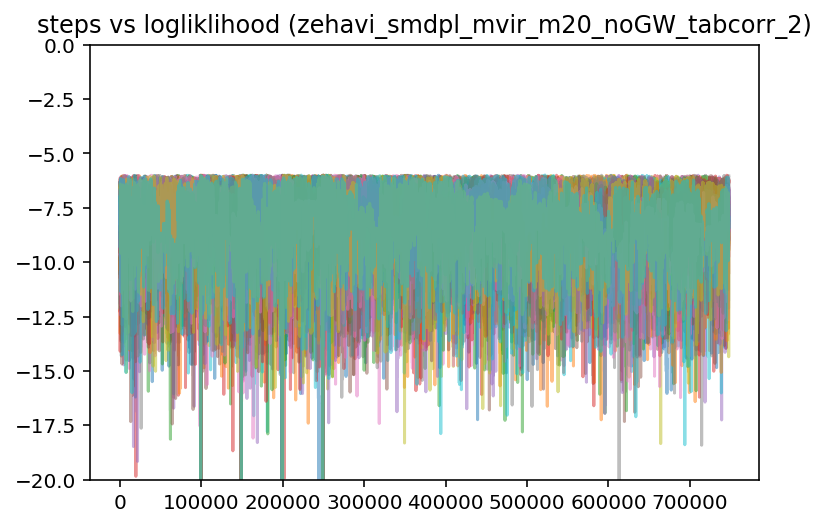

In [37]:
plt.plot(log_prob_samples[:,:],alpha=0.5)
#plt.ylim(-600,20)
plt.title("steps vs logliklihood ({})".format(fname[:-3]))
max_ll = log_prob_samples[:,:].max()
plt.ylim(-20,0)
F"Max logliklihood: {max_ll}"
plt.savefig('steps_v_llike'+fname[:-3]+'.png')
plt.show()

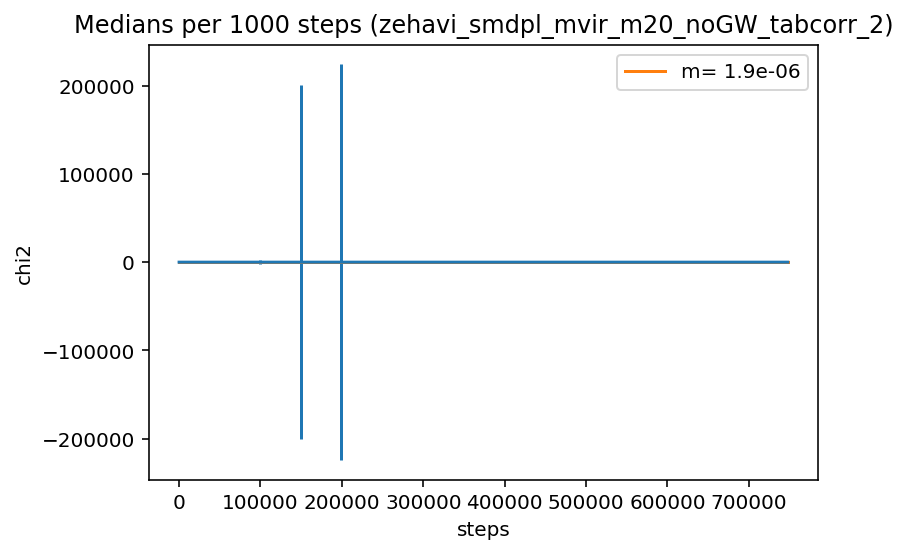

In [38]:
#For one chain, bin chi2s in bins of 1000 steps and take the median and std value per bin
intvl = 1000
chain_num = 1
n = int(len(log_prob_samples)/intvl)
steps = np.linspace(0,n*intvl,n)
meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(-2*log_prob_samples[i*intvl:(i+1)*intvl,chain_num])
    stds[i]+=np.std(-2*log_prob_samples[i*intvl:(i+1)*intvl,chain_num])

plt.errorbar(steps,meds,yerr=1.23*stds)
m,b = np.polyfit(steps,meds,deg=1)[0],np.polyfit(steps,meds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m= {}'.format(round(m,7)))
plt.ylabel('chi2')
plt.xlabel('steps')
plt.title('Medians per 1000 steps ({})'.format(fname[:-3]))
plt.legend()
plt.savefig('med_chi2_'+fname[:-3]+'.png')


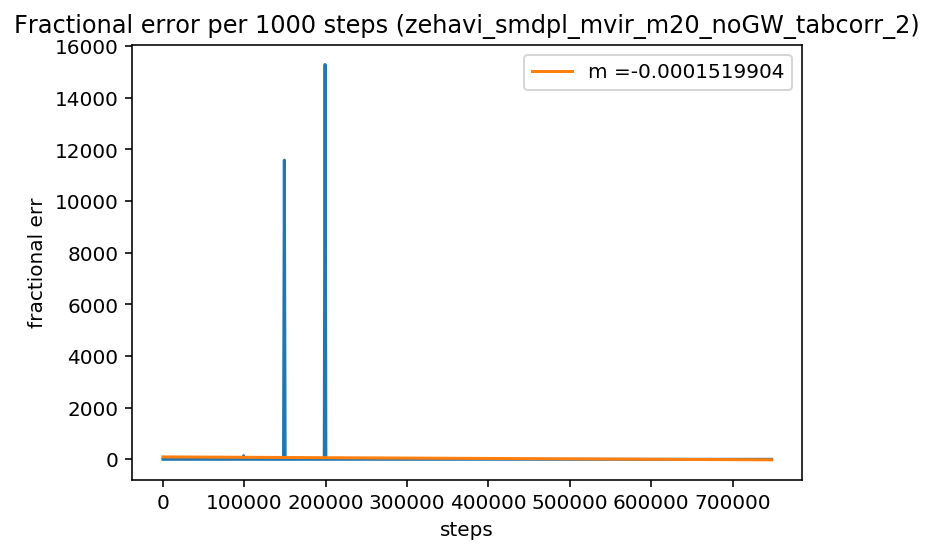

In [39]:
#fractional error of the same data as above
plt.plot(steps,1.23*stds/meds)
m,b = np.polyfit(steps,1.23*stds/meds,deg=1)[0],np.polyfit(steps,1.23*stds/meds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m ={}'.format(round(m,10)))
plt.ylabel('fractional err')
plt.xlabel('steps')
plt.title('Fractional error per 1000 steps ({})'.format(fname[:-3]))
plt.legend()
plt.savefig('med_chi2_err_'+fname[:-3]+'.png')

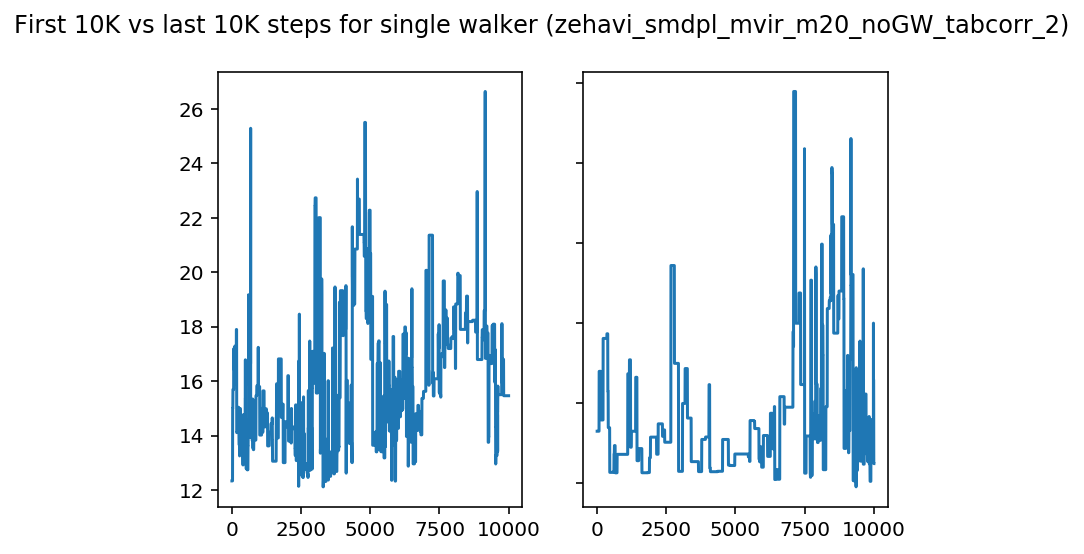

In [40]:
#plot first and last 10000 chi2 values for a single walker
steps = np.linspace(0,10_000,10_000)
chain_num = 1
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('First 10K vs last 10K steps for single walker ({})'.format(fname[:-3]))
ax1.plot(steps, -2*log_prob_samples[0:len(steps),chain_num])
ax2.plot(steps, -2*log_prob_samples[-len(steps):len(log_prob_samples),chain_num])
for ax in fig.get_axes():
    ax.label_outer()
plt.savefig('begin_end_chains_'+fname[:-3]+'.png')

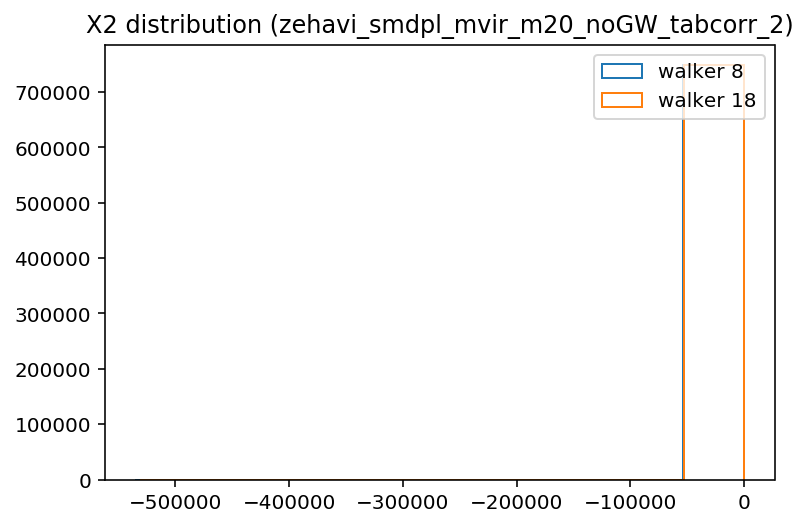

'Mean for walker 8: -20.43360146616517'

In [41]:
i = 8
def ind(i):
    if i < 35:
        j = i+10
    else: j = 35
    return j

counts,edges = np.histogram(log_prob_samples[row,col])
mean = np.mean(edges)
plt.hist(log_prob_samples[:,i],histtype='step',label='walker'+' ' + str(i))
plt.hist(log_prob_samples[:,ind(i)],histtype='step',label='walker'+' ' + str(ind(i)))
plt.legend()
#plt.xlim(-0.5e6,1e5)
plt.title("X2 distribution ({})".format(fname[:-3]))
plt.show()
F"Mean for walker {i}: {mean}"

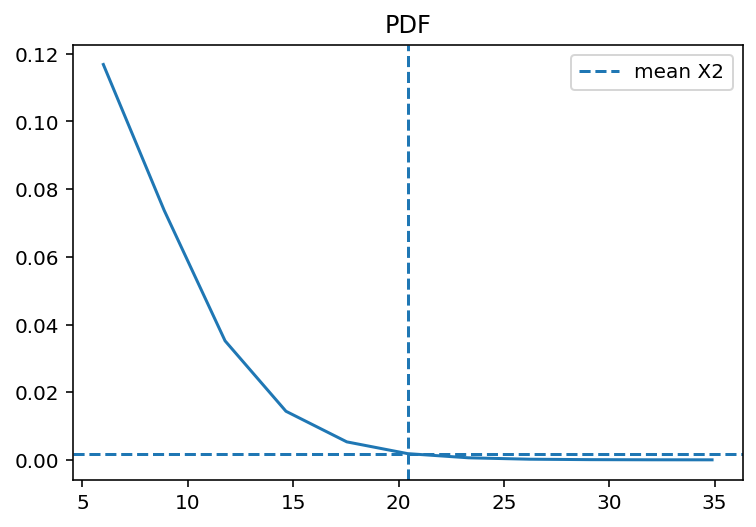

'PDF Mean: 0.001834767009001989'

In [42]:
pdf = chi2.pdf(-1*edges,deg_of_frdm)
plt.plot(-edges,pdf)
plt.axvline(-mean,linestyle='--',label='mean X2')
plt.axhline(chi2.pdf(-1*mean,deg_of_frdm),linestyle='--')
plt.title("PDF")
plt.legend()
plt.show()
F"PDF Mean: {chi2.pdf(-1*mean,deg_of_frdm)}"

In [43]:
mode = stats.mode(2*log_prob_samples[:])

cdf = chi2.cdf(-np.mean(mode[0]),deg_of_frdm)
print("pval =", 1-cdf)

cdf = chi2.cdf((-2*log_prob_samples[:].max()),deg_of_frdm)
print("pval chi2 min =", 1-cdf)

cdf = chi2.cdf(np.mean(-2*log_prob_samples[row,col]),deg_of_frdm)
print("pval =", 1-cdf)

pval = 0.02692002155717521
pval chi2 min = 0.10110905592498542
pval = 0.028533824221794624


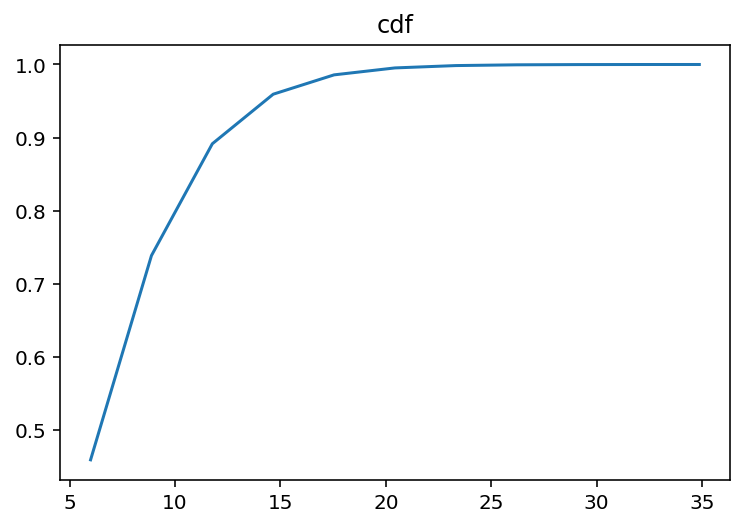

In [44]:
cdf = chi2.cdf(-1*edges,7)
plt.plot(-edges,cdf)
plt.title("cdf")
plt.show()

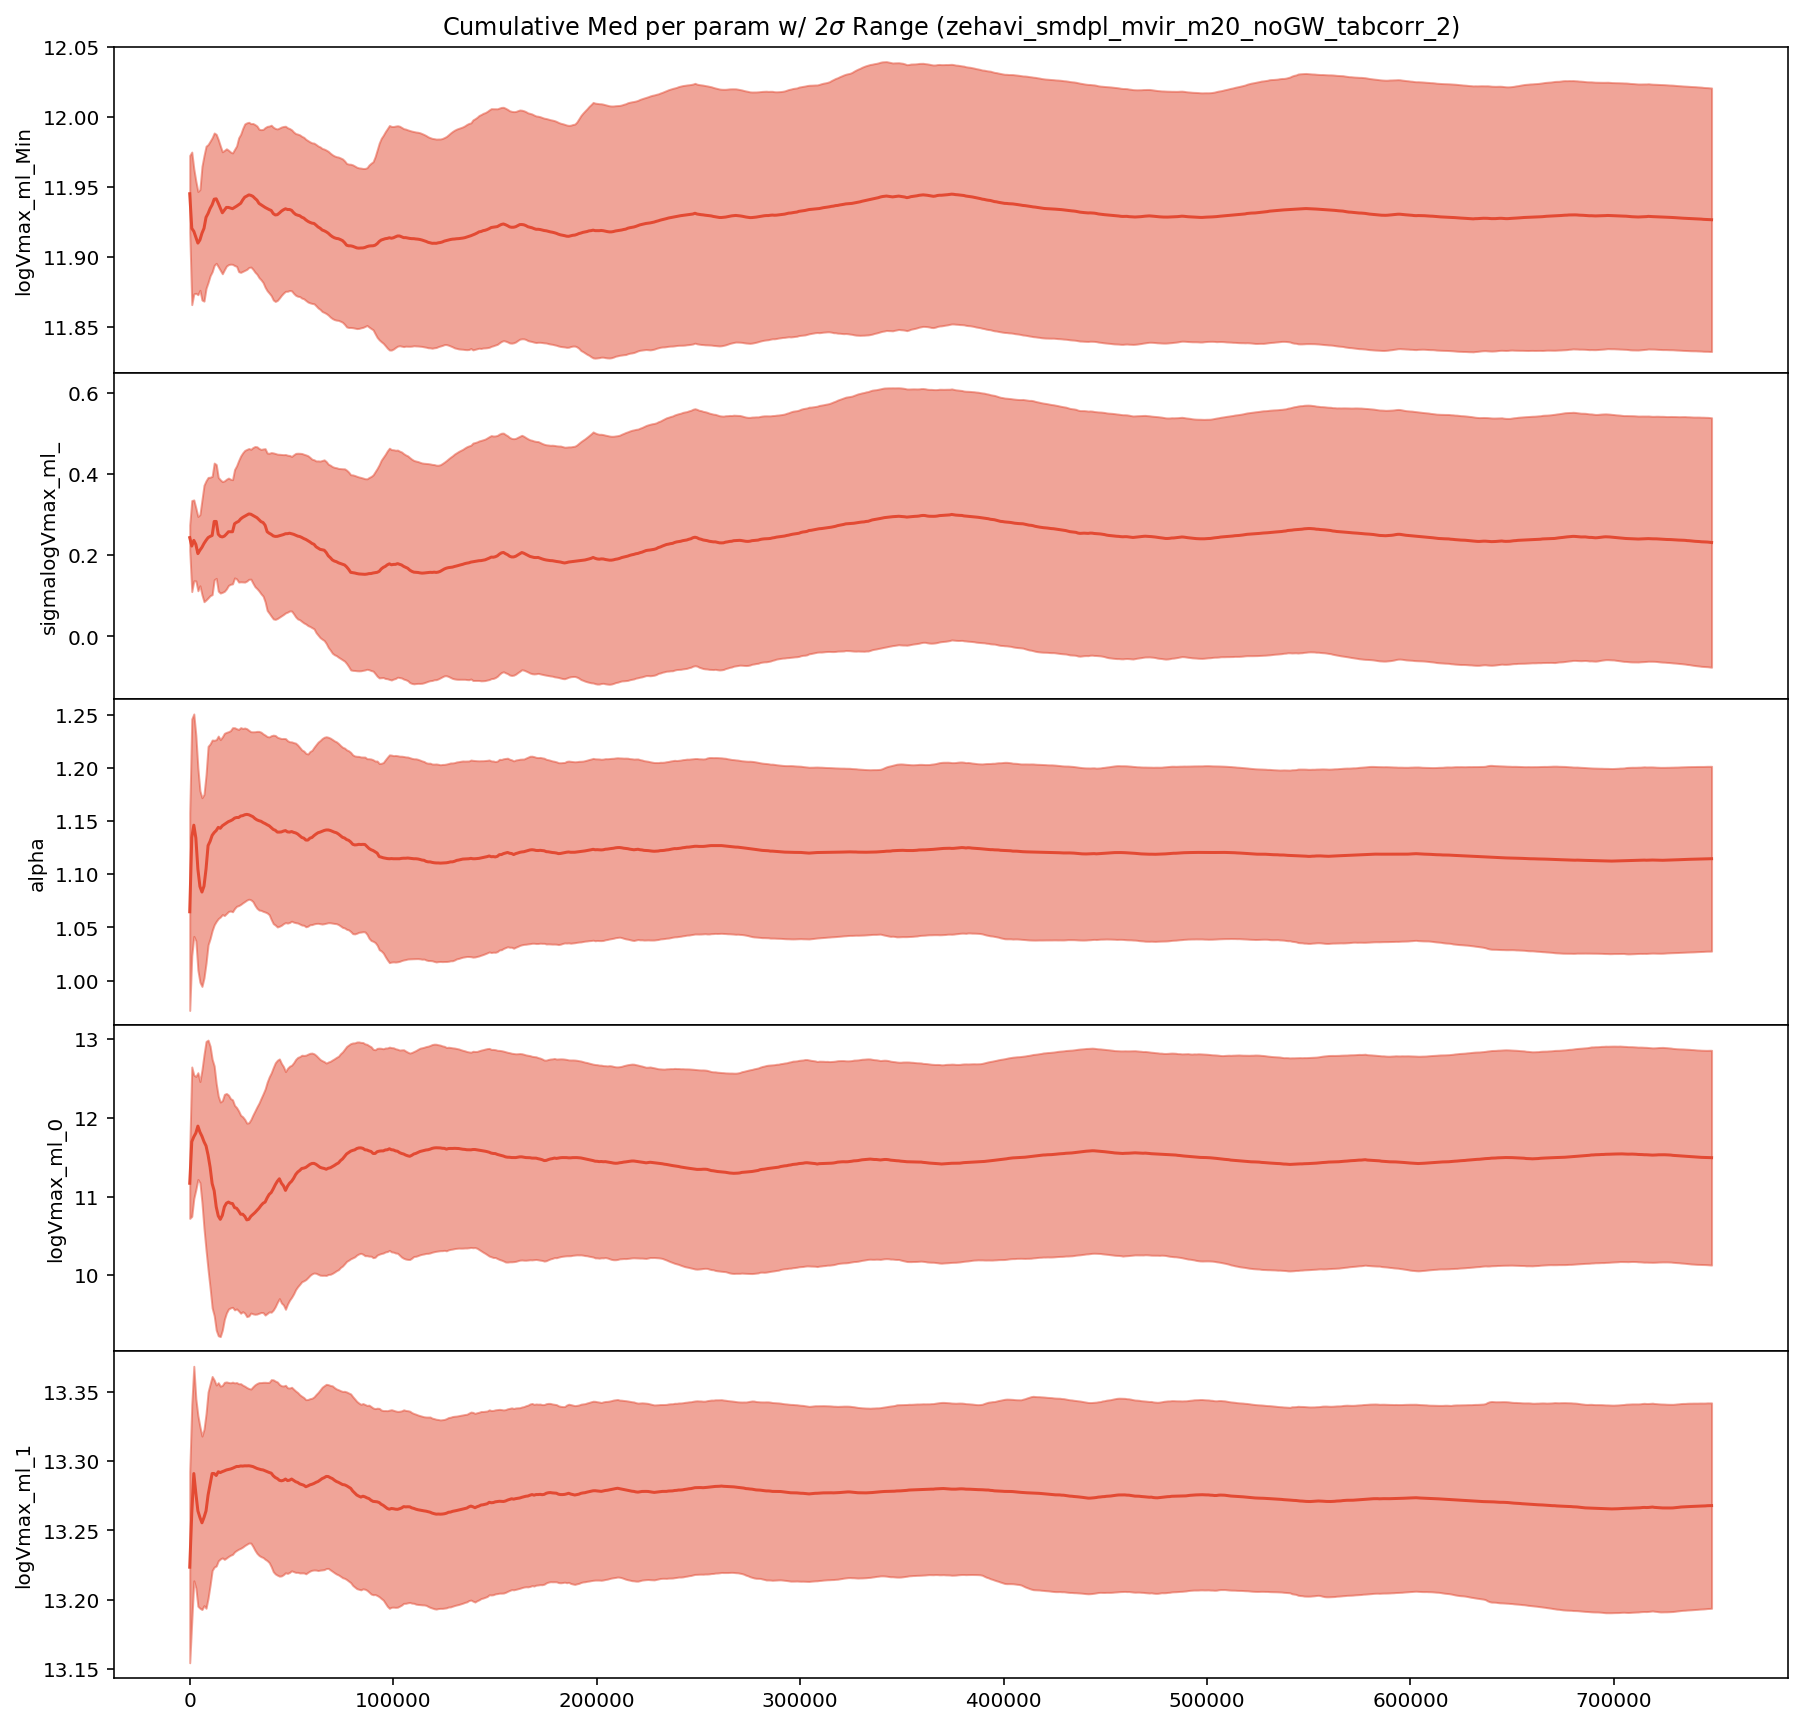

In [45]:
j = 4 #walker number
c = ['#e34a33']#['#fee8c8','#fdbb84','#e34a33']
intvl = 1000 #steps to take median over
n = int(len(samples)/intvl)
steps = np.linspace(0,n*intvl,n)

fig, axs = plt.subplots(5,figsize=(15,15),gridspec_kw={'hspace': 0},sharex=True)
meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,0])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,0],ddof=1)
axs[0].plot(steps,meds,c= c[0])
axs[0].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[0].set(ylabel='log{}Min'.format(param))
axs[0].set(title='Cumulative Med per param w/ 2$\sigma$ Range ({})'.format(fname[:-3]))

meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,1])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,1],ddof=1)
axs[1].plot(steps,meds,c= c[0])
axs[1].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[1].set(ylabel='sigmalog{}'.format(param))


meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,2])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,2],ddof=1)
axs[2].plot(steps,meds,c= c[0])
axs[2].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[2].set(ylabel='alpha')


meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,3])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,3],ddof=1)
axs[3].plot(steps,meds,c= c[0])
axs[3].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[3].set(ylabel='log{}0'.format(param))

meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(samples[0:(i+1)*intvl,j,4])
    stds[i]+=np.std(samples[0:(i+1)*intvl,j,4],ddof=1)
axs[4].plot(steps,meds,c= c[0])
axs[4].fill_between(steps, meds-2*stds, meds+2*stds,color = '#e34a33',alpha = 0.5)
axs[4].set(ylabel='log{}1'.format(param))


plt.savefig('param_v_step_'+fname[:-3]+'.png')

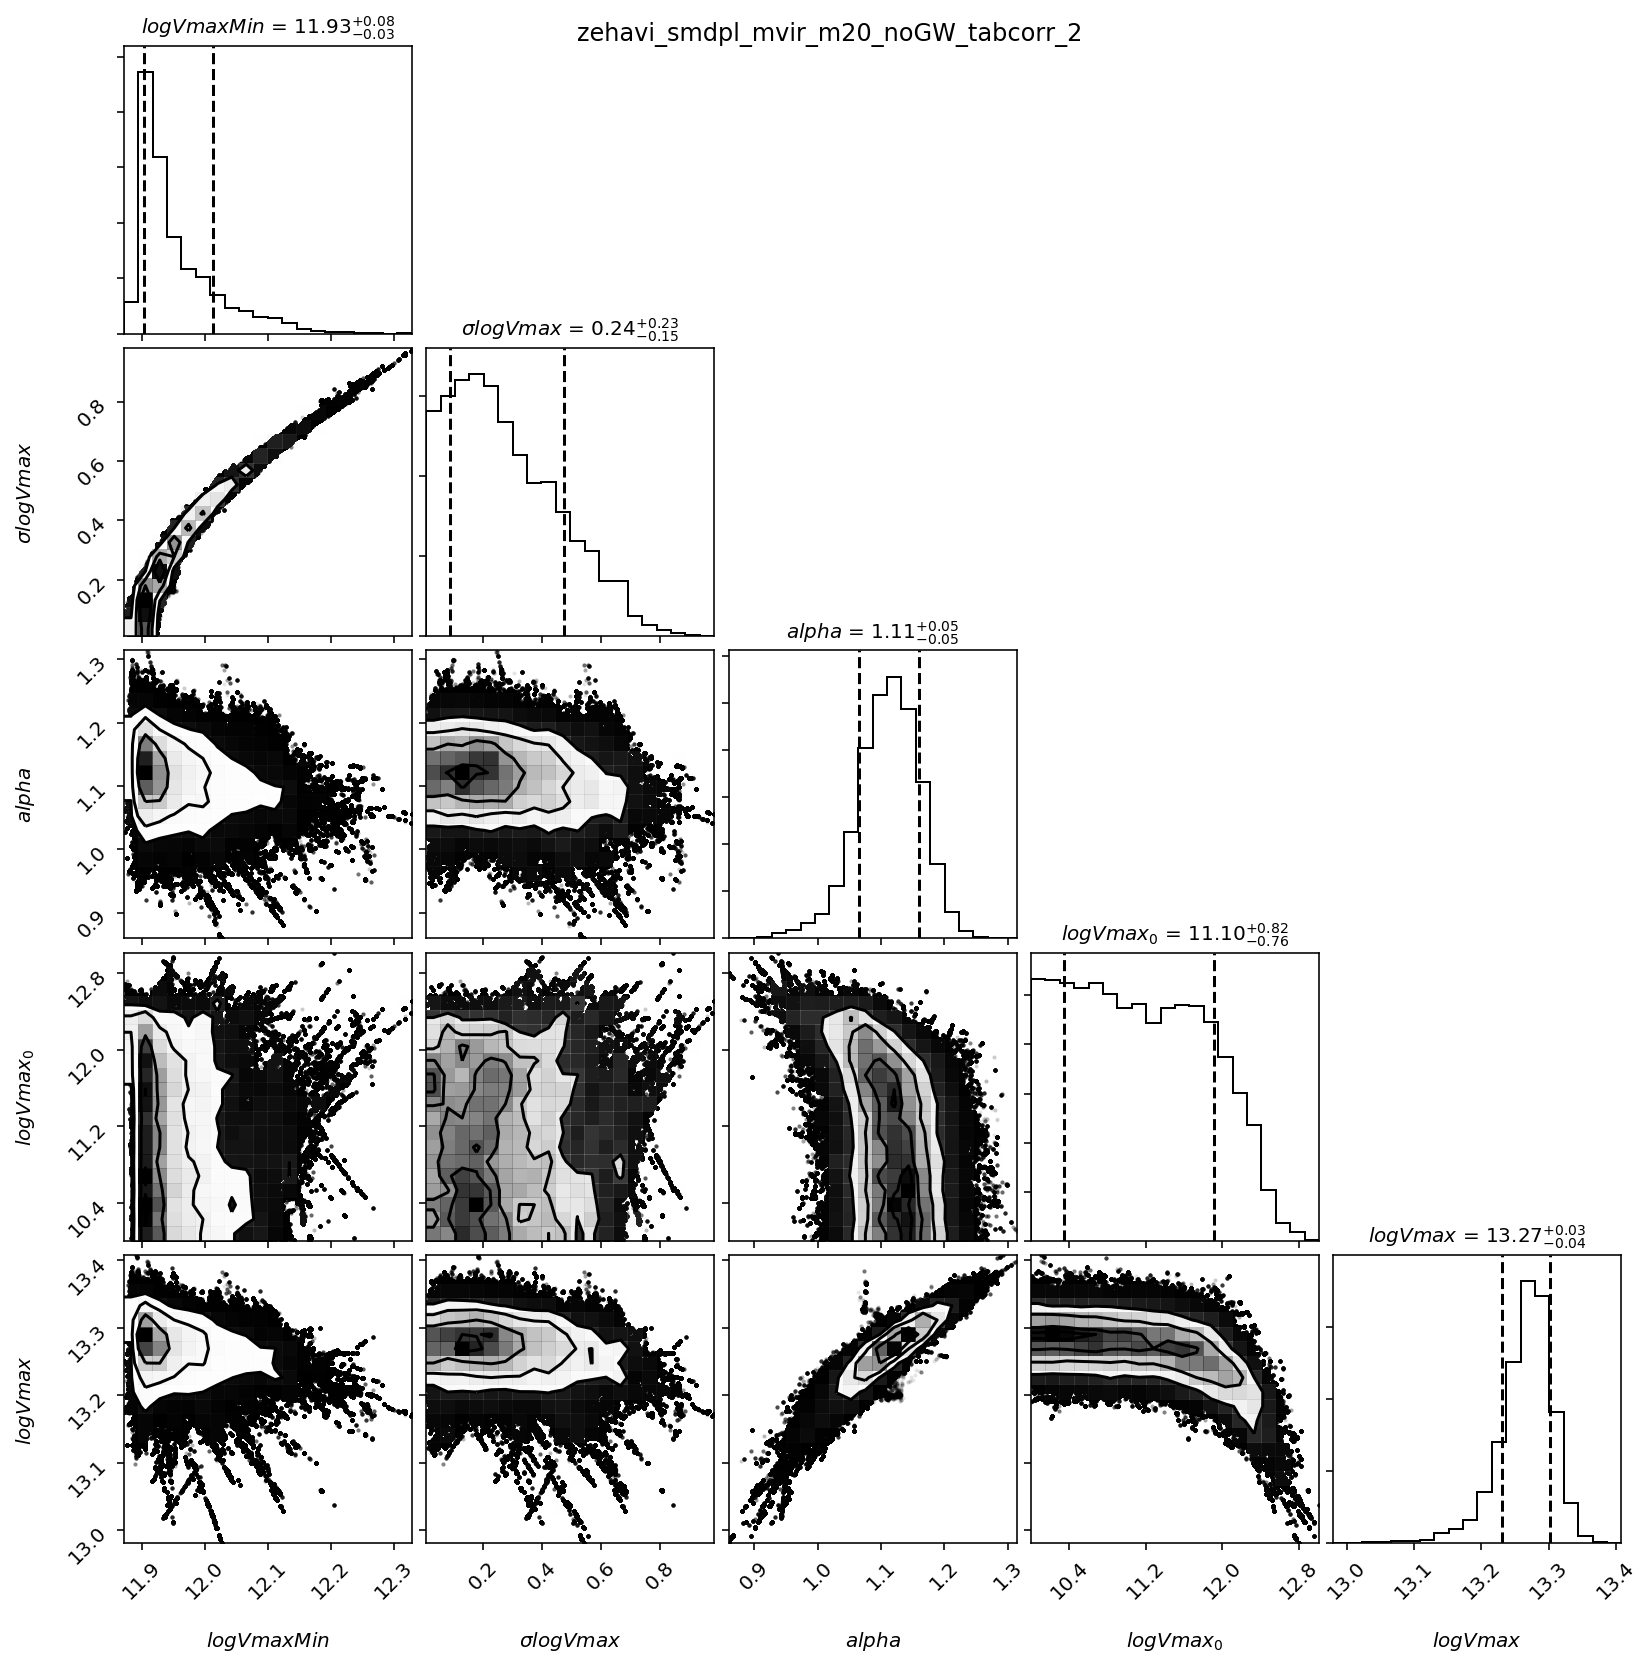

In [46]:
ndim=5
fig = corner.corner(samples.reshape((-1,ndim)),
        labels=["$logVmaxMin$", "${\sigma}logVmax$", "$alpha$", "$logVmax_0$", "$logVmax$"],
        show_titles=True,title_kwargs={"fontsize": 10},quantiles=(0.16, 0.84))#, levels=(1-np.exp(-0.5),))
fig.suptitle('{}'.format(fname[:-3]))
plt.savefig('corner_'+fname[:-3]+'.png')

# Single Param Stats

In [105]:
#fname = "combo_param_mv_fit_m21.h5"
fname = "combo_param_allparam_fit_m21
print('{}'.format(fname,fname))

combo_param_allparam_fit_m21.h5


In [106]:
files = [fname]

#files = [fname4,fname5]
s = []
log_prob_s = []
wp = []

for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=100, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=100, flat=False, thin=1))
    wp.append(reader.get_blobs(discard=100))
    
print(np.shape(wp))
print(np.shape(s))
print(np.shape(log_prob_s))

(1,)
(1, 0, 35, 6)
(1, 0, 35)


In [107]:
max_n = reader.iteration
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

tau = reader.get_autocorr_time(tol=0)
autocorr[index] = np.mean(tau)
index += 1

# Check convergence
converged = (tau * 100 < reader.iteration)
converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
old_tau = tau
print(converged,tau)

[False False False False False False] [6.2007396  5.16515519 5.53090312 6.26623175 6.22788426 6.23374074]


In [108]:
if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wp[i+1]))
else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]

In [273]:
print("Min chi2:",round(-2*log_prob_samples.max(),3))
print("Min chi2 params:",list(np.array(samples[np.where(log_prob_samples==log_prob_samples.max())]))[0])
min_chi2_loc = np.where((-2*log_prob_samples.max())==-2*log_prob_samples)
#print(wp_samples[min_chi2_loc][-1])

Min chi2: 4.375
Min chi2 params: [ 0.98557091 12.50638726  0.11806538  0.99936361 13.03079781 13.68001562]


In [100]:
log_prob_samples

array([[-872.61540318, -873.88788003, -881.94564782, ..., -864.96366564,
        -890.09807035, -858.2056333 ],
       [-872.61540318, -873.88788003, -881.94564782, ..., -864.96366564,
        -890.09807035, -858.2056333 ],
       [-872.61540318, -873.88788003, -881.94564782, ..., -864.96366564,
        -890.09807035, -858.2056333 ],
       ...,
       [-878.20701099, -871.37880012, -861.48938494, ..., -859.64315849,
        -864.37055991, -858.2056333 ],
       [-878.20701099, -871.37880012, -861.48938494, ..., -859.64315849,
        -864.37055991, -858.2056333 ],
       [-878.20701099, -871.37880012, -861.48938494, ..., -859.64315849,
        -864.37055991, -858.2056333 ]])

In [101]:
#calculate chi2 per degree of freedom
deg_of_frdm = 11
chi_per_deg = -2.0*log_prob_samples/deg_of_frdm
print("chi2 per dof:", chi_per_deg.min())
print('median,max,std: ',np.median(-2.0*log_prob_samples),np.max(-2.0*log_prob_samples),np.std(-2.0*log_prob_samples))
row,col = np.where(chi_per_deg<50000.)
#randomly select 20 sets of parameters with chi2 per dof less than 6.5
choices = np.random.choice(samples[row,col].shape[0],10,replace=False)
param_string_sampling = samples[row,col][choices]
#print("Sets of parameters with chi2 per dof < 6.5")
param_sampling = []
for i in param_string_sampling:
    param_sampling.append(list(np.array(i)))
    #param_sampling.append(list(np.array(param_string_sampling)))
#print(-2.0*log_prob_samples[row,col][choices])

chi2 per dof: 154.28822123961228
median,max,std:  1736.5341279885597 1832.1784654336743 18.18961188944427


In [102]:
#Calculate median M1 HOD parameter with upper and lower limits at 16th and 84th percentiles
a_vals = np.zeros(len(param_sampling))
for i in range(len(param_sampling)):
    a_vals[i]+=param_sampling[i][0]
lo = np.median(a_vals)-np.percentile(a_vals,16)
hi = np.percentile(a_vals,84)-np.median(a_vals)
print(f"median a val: {round(np.median(a_vals),4)} (+{round(lo,4)},-{round(hi,4)})")

median a val: 0.8075 (+0.0029,-0.0026)


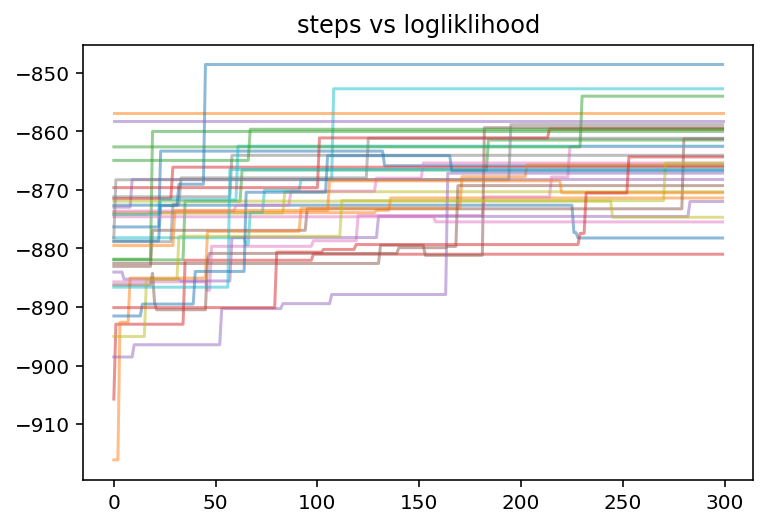

'Max logliklihood: -848.5852168178676'

In [103]:
plt.plot(log_prob_samples[:,:],alpha=0.5)
#plt.ylim(-600,20)
plt.title("steps vs logliklihood")
max_ll = log_prob_samples[:,:].max()
plt.show()
F"Max logliklihood: {max_ll}"

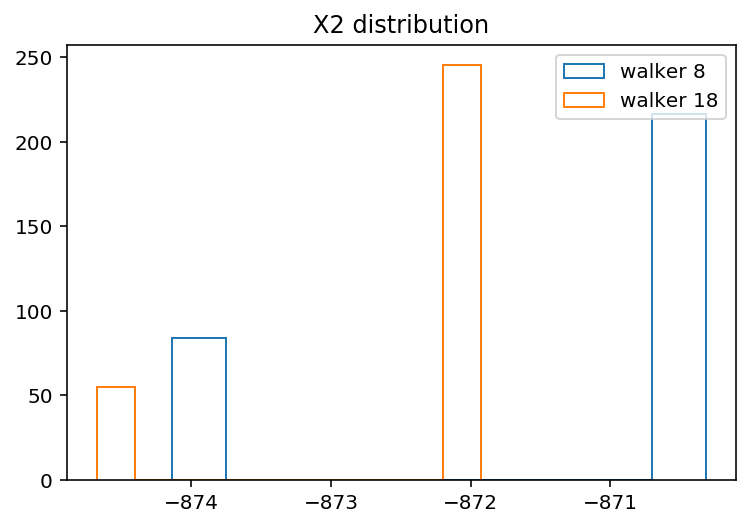

'Mean for walker 8: -882.3372247673524'

In [104]:
i = 8
def ind(i):
    if i < 35:
        j = i+10
    else: j = 35
    return j

counts,edges = np.histogram(log_prob_samples[row,col])
mean = np.mean(edges)
plt.hist(log_prob_samples[:,i],histtype='step',label='walker'+' ' + str(i))
plt.hist(log_prob_samples[:,ind(i)],histtype='step',label='walker'+' ' + str(ind(i)))
plt.legend()
#plt.xlim(-0.5e6,1e5)
plt.title("X2 distribution")
plt.show()
F"Mean for walker {i}: {mean}"

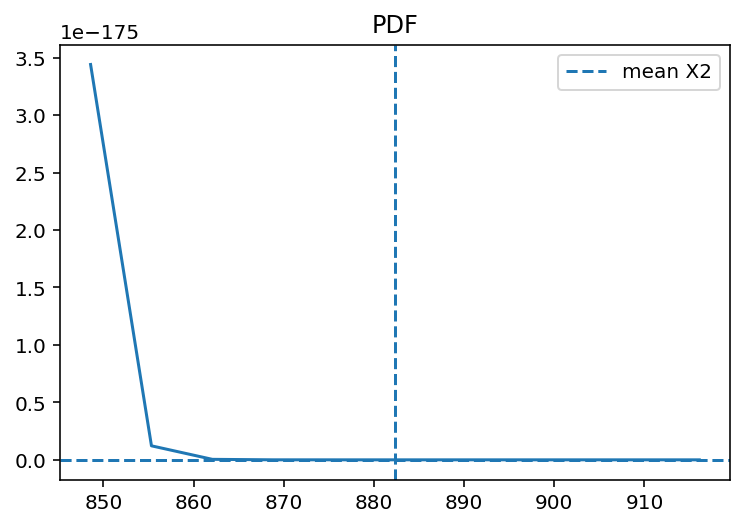

'PDF Mean: 1.921940856587559e-182'

In [81]:
pdf = chi2.pdf(-1*edges,deg_of_frdm)
plt.plot(-edges,pdf)
plt.axvline(-mean,linestyle='--',label='mean X2')
plt.axhline(chi2.pdf(-1*mean,deg_of_frdm),linestyle='--')
plt.title("PDF")
plt.legend()
plt.show()
F"PDF Mean: {chi2.pdf(-1*mean,deg_of_frdm)}"

In [82]:
mode = stats.mode(2*log_prob_samples[:])

cdf = chi2.cdf(-np.mean(mode[0]),deg_of_frdm)
print("pval =", 1-cdf)

cdf = chi2.cdf((-2*log_prob_samples[:].max()),deg_of_frdm)
print("pval chi2 min =", 1-cdf)

cdf = chi2.cdf(np.mean(-2*log_prob_samples[row,col]),deg_of_frdm)
print("pval =", 1-cdf)

pval = 0.0
pval chi2 min = 0.0
pval = 0.0


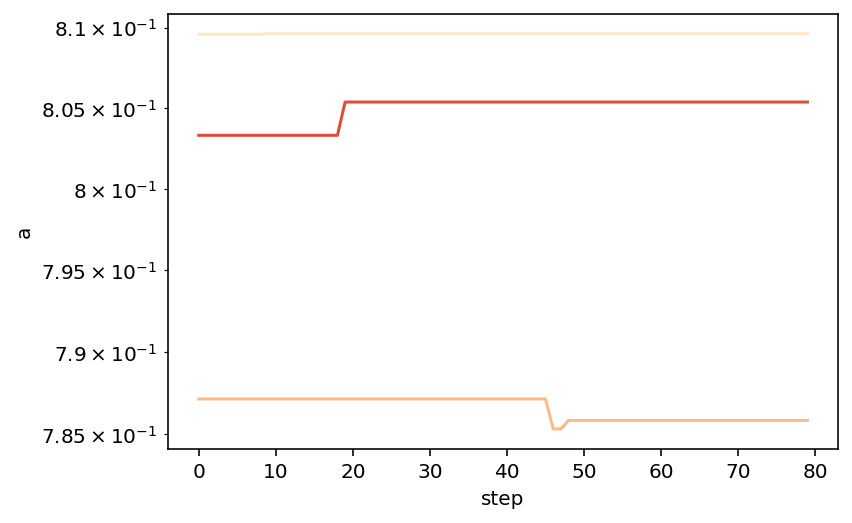

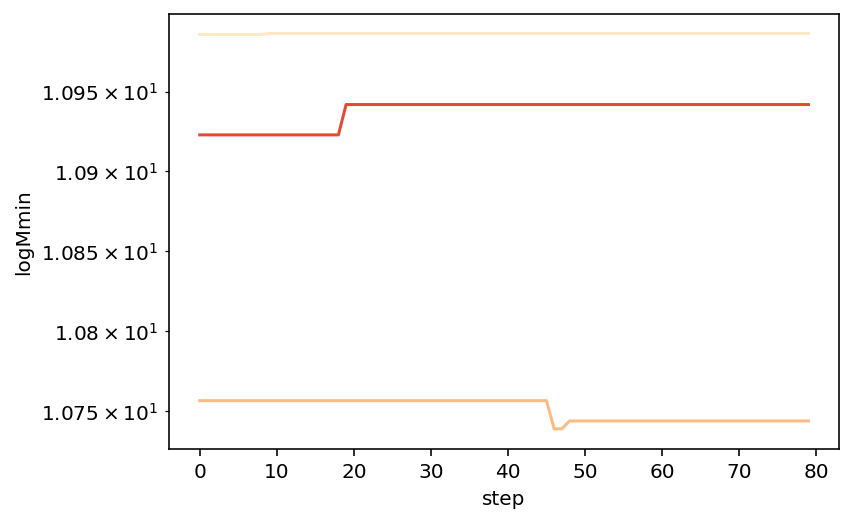

In [83]:
j = 4
c = ['#fee8c8','#fdbb84','#e34a33']
for i in range(3):
    plt.plot(samples[:,i+j,0],c= c[-i])
#plt.xlim(500,4000)                                                               
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('a')
plt.show()
for i in range(3):
    plt.plot(samples[:,i+j,1],c= c[-i])
#plt.xlim(500,4000)                                                               
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('logMmin')
plt.show()

# 6 Param Stats

In [54]:
#fname = "combo_param_allparam_fit_a97_100_m21.h5"
fname = "combo_param_allparam_fit_a0_m21.h5"
#fname = "combo_param_allparam_fit_a0_m21.h5
print('{}'.format(fname,fname))

combo_param_allparam_fit_a0_m21.h5


In [55]:
files = [fname]

#files = [fname4,fname5]
s = []
log_prob_s = []
wp = []

for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=1000, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=1000, flat=False, thin=1))
    wp.append(reader.get_blobs(discard=1000))
    
print(np.shape(wp))
print(np.shape(s))
print(np.shape(log_prob_s))

(1,)
(1, 74000, 35, 6)
(1, 74000, 35)


In [56]:
max_n = reader.iteration
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

tau = reader.get_autocorr_time(tol=0)
autocorr[index] = np.mean(tau)
index += 1

# Check convergence
converged = (tau * 100 < reader.iteration)
converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
old_tau = tau
print(converged,tau)

[False False False False False False] [2415.36863017 2410.24724571 4012.34492729 4552.72211765 2503.56204897
 2791.93202244]


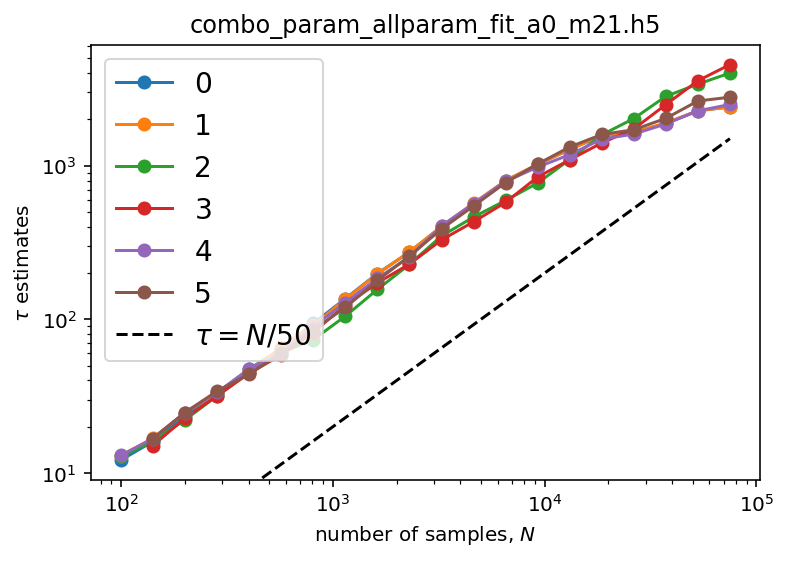

In [57]:
for j in range(6):
    chain = reader.get_chain()[:,:,j].T
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 20)).astype(int)
    #gw2010 = np.empty(len(N))
    new = np.empty(len(N))
    for i, n in enumerate(N):
        #gw2010[i] = autocorr_gw2010(chain[:, :n])
        new[i] = autocorr_new(chain[:, :n])

    # Plot the comparisons
    #plt.loglog(N, gw2010, "o-", label="G\&W 2010")
    plt.loglog(N, new, "o-", label=str(j))
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.title(str(fname))
plt.legend(fontsize=14);
plt.savefig("autocorr_"+fname[:-3]+".png")

In [58]:
if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wp[i+1]))
else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wp[0]

In [59]:
print("Min chi2/dof:",round(-2*log_prob_samples.max(),3)/6)
print("Min chi2 params:",list(np.array(samples[np.where(log_prob_samples==log_prob_samples.max())]))[0])
min_chi2_loc = np.where((-2*log_prob_samples.max())==-2*log_prob_samples)
#print(wp_samples[min_chi2_loc][-1])

Min chi2/dof: 0.3478333333333334
Min chi2 params: [0.02375223 2.71201315 0.11299189 2.22089537 2.74328734 2.886974  ]


In [408]:
#calculate chi2 per degree of freedom
deg_of_frdm = 6
chi_per_deg = -2.0*log_prob_samples/deg_of_frdm
print("chi2 per dof:", chi_per_deg.min())
print('median,max,std: ',np.median(-2.0*log_prob_samples),np.max(-2.0*log_prob_samples),np.std(-2.0*log_prob_samples))
row,col = np.where(chi_per_deg<75.)
#randomly select 20 sets of parameters with chi2 per dof less than 6.5
choices = np.random.choice(samples[row,col].shape[0],10,replace=False)
param_string_sampling = samples[row,col][choices]
#print("Sets of parameters with chi2 per dof < 6.5")
param_sampling = []
for i in param_string_sampling:
    param_sampling.append(list(np.array(i)))
    #param_sampling.append(list(np.array(param_string_sampling)))
#print(-2.0*log_prob_samples[row,col][choices])

chi2 per dof: 0.3203861679339363
median,max,std:  10.575013930090922 42.139150748610504 3.9420537839647256


In [409]:
#Calculate median M1 HOD parameter with upper and lower limits at 16th and 84th percentiles
a_vals = np.zeros(len(param_sampling))
for i in range(len(param_sampling)):
    a_vals[i]+=param_sampling[i][0]
lo = np.median(a_vals)-np.percentile(a_vals,16)
hi = np.percentile(a_vals,84)-np.median(a_vals)
print(f"median a val: {round(np.median(a_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
M0_vals = np.zeros(len(param_sampling))
M1_vals = np.zeros(len(param_sampling))
sigma_vals = np.zeros(len(param_sampling))
alpha_vals = np.zeros(len(param_sampling))
logMmin_vals = np.zeros(len(param_sampling))
for i in range(len(param_sampling)):
    logMmin_vals[i]+=param_sampling[i][1]
    alpha_vals[i]+=param_sampling[i][2]
    sigma_vals[i]+=param_sampling[i][3]
    M0_vals[i]+=param_sampling[i][4]
    M1_vals[i]+=param_sampling[i][5]
lo = np.median(logMmin_vals)-np.percentile(logMmin_vals,16)
hi = np.percentile(logMmin_vals,84)-np.median(logMmin_vals)
print(f"median logMmin val: {round(np.median(logMmin_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(alpha_vals)-np.percentile(alpha_vals,16)
hi = np.percentile(alpha_vals,84)-np.median(alpha_vals)
print(f"median alpha val: {round(np.median(alpha_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(sigma_vals)-np.percentile(sigma_vals,16)
hi = np.percentile(sigma_vals,84)-np.median(sigma_vals)
print(f"median sigma val: {round(np.median(sigma_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(M0_vals)-np.percentile(M0_vals,16)
hi = np.percentile(M0_vals,84)-np.median(M0_vals)
print(f"median M0 val: {round(np.median(M0_vals),4)} (+{round(lo,4)},-{round(hi,4)})")
lo = np.median(M1_vals)-np.percentile(M1_vals,16)
hi = np.percentile(M1_vals,84)-np.median(M1_vals)
print(f"median M1 val: {round(np.median(M1_vals),4)} (+{round(lo,4)},-{round(hi,4)})")

median a val: 0.9849 (+0.0046,-0.0066)
median logMmin val: 12.5805 (+0.1175,-0.0461)
median alpha val: 0.2447 (+0.1712,-0.2524)
median sigma val: 1.165 (+0.1288,-0.0847)
median M0 val: 12.546 (+1.2788,-0.3291)
median M1 val: 13.7942 (+0.0593,-0.0556)


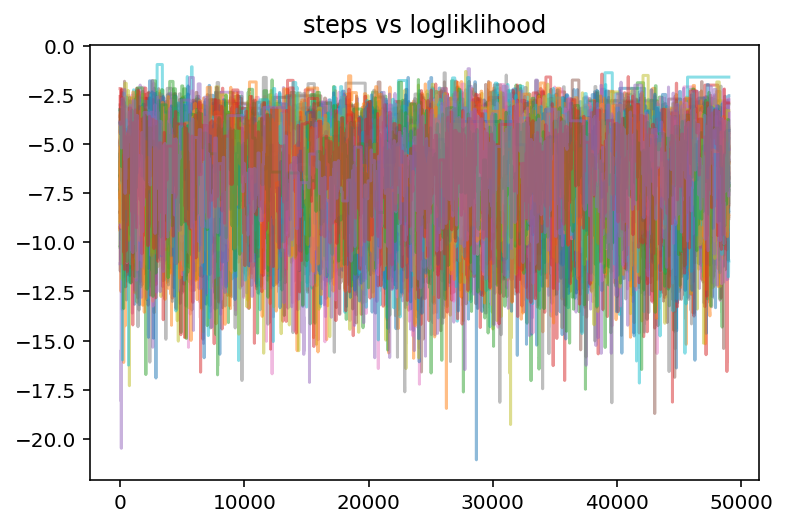

'Max logliklihood: -0.9611585038018089'

In [265]:
plt.plot(log_prob_samples[:,:],alpha=0.5)
#plt.ylim(-600,20)
plt.title("steps vs logliklihood")
max_ll = log_prob_samples[:,:].max()
plt.show()
F"Max logliklihood: {max_ll}"

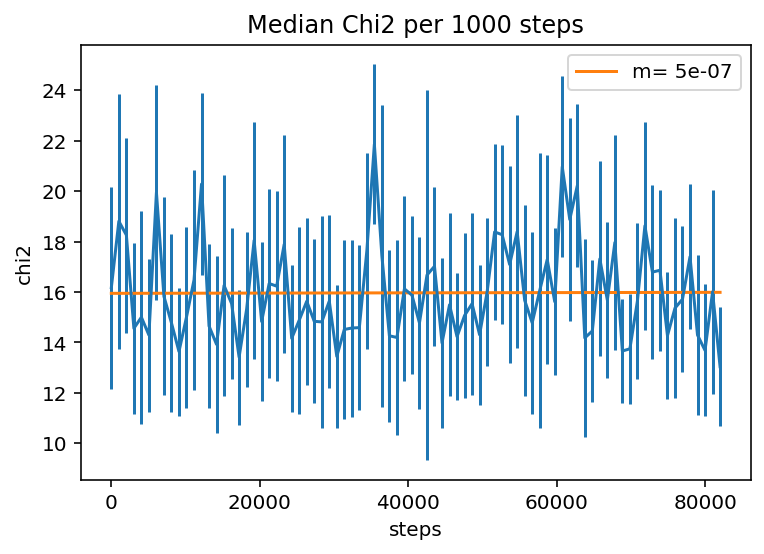

In [299]:
intvl = 1000
chain_num = 1
n = int(len(log_prob_samples)/intvl)
steps = np.linspace(0,n*intvl,n)
ameds = np.zeros(n)
astds = np.zeros(n)
meds = np.zeros(n)
stds = np.zeros(n)
for i in range(n):
    meds[i]+=np.median(-2*log_prob_samples[i*intvl:(i+1)*intvl,chain_num])
    stds[i]+=np.std(-2*log_prob_samples[i*intvl:(i+1)*intvl,chain_num])
    ameds[i]+=np.median(samples[i*intvl:(i+1)*intvl,chain_num,0])
    astds[i]+=np.std(samples[i*intvl:(i+1)*intvl,chain_num,0])
plt.errorbar(steps,meds,yerr=1.23*stds)
m,b = np.polyfit(steps,meds,deg=1)[0],np.polyfit(steps,meds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m= {}'.format(round(m,7)))
plt.ylabel('chi2')
plt.xlabel('steps')
plt.title('Median Chi2 per {} steps'.format(intvl))
plt.legend()
plt.savefig("med_chi2_err"+fname[:-3]+".png")


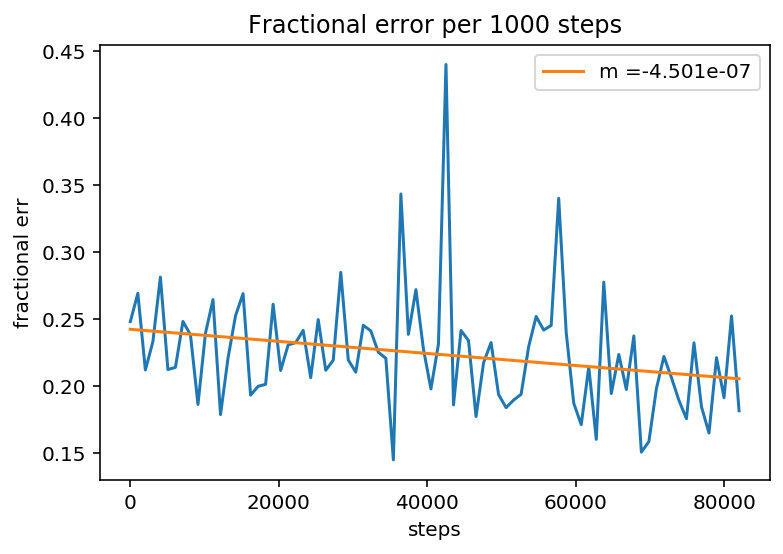

In [300]:
plt.plot(steps,1.23*stds/meds)
m,b = np.polyfit(steps,1.23*stds/meds,deg=1)[0],np.polyfit(steps,1.23*stds/meds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m ={}'.format(round(m,10)))
plt.ylabel('fractional err')
plt.xlabel('steps')
plt.title('Fractional error per {} steps'.format(intvl))
plt.legend()
plt.savefig("med_chi2_err"+fname[:-3]+".png")


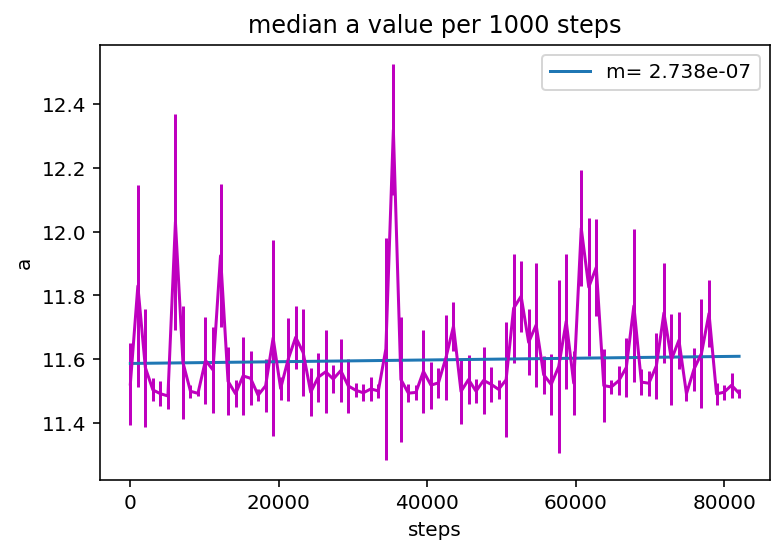

In [301]:
plt.errorbar(steps,ameds,yerr=1.23*astds,c='m')
m,b = np.polyfit(steps,ameds,deg=1)[0],np.polyfit(steps,ameds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m= {}'.format(round(m,10)))
plt.ylabel('a')
plt.xlabel('steps')
plt.title('median a value per {} steps'.format(intvl))
plt.legend()
plt.savefig("med_a_"+fname[:-3]+".png")


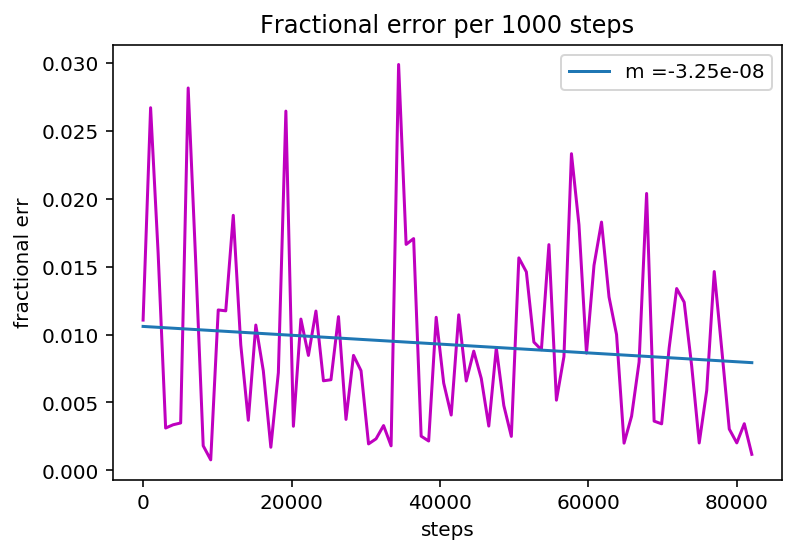

In [302]:
plt.plot(steps,1.23*astds/ameds,c='m')
m,b = np.polyfit(steps,1.23*astds/ameds,deg=1)[0],np.polyfit(steps,1.23*astds/ameds,deg=1)[1]
plt.plot(steps,m*steps+b,label='m ={}'.format(round(m,10)))
plt.ylabel('fractional err')
plt.xlabel('steps')
plt.title('Fractional error per {} steps'.format(intvl))
plt.legend()
plt.savefig("med_a_err_"+fname[:-3]+".png")

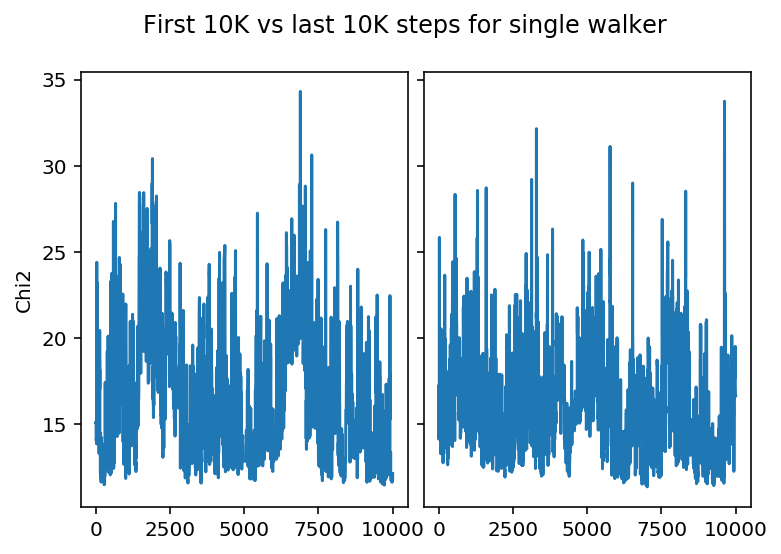

In [316]:
#plot first and last 10000 chi2 values for a single walker
steps = np.linspace(0,10_000,10_000)
chain_num = 1
fig, (ax1, ax2) = plt.subplots(1, 2,sharey = True,gridspec_kw={'wspace': 0.05})
fig.suptitle('First 10K vs last 10K steps for single walker')
ax1.plot(steps, -2*log_prob_samples[0:len(steps),chain_num])
ax1.set(ylabel='Chi2')
ax2.plot(steps, -2*log_prob_samples[-len(steps):len(log_prob_samples),chain_num])
for ax in fig.get_axes():
    ax.label_outer()
plt.savefig('comp_begin_end_chains_'+fname[:-3]+'.png')

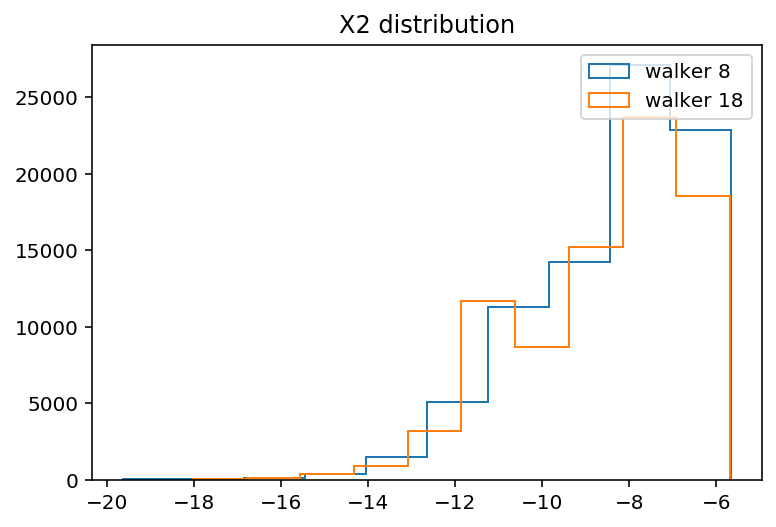

'Mean for walker 8: -14.311166685878812'

In [317]:
i = 8
def ind(i):
    if i < 35:
        j = i+10
    else: j = 35
    return j

counts,edges = np.histogram(log_prob_samples[row,col])
mean = np.mean(edges)
plt.hist(log_prob_samples[:,i],histtype='step',label='walker'+' ' + str(i))
plt.hist(log_prob_samples[:,ind(i)],histtype='step',label='walker'+' ' + str(ind(i)))
plt.legend()
#plt.xlim(-0.5e6,1e5)
plt.title("X2 distribution")
plt.show()
F"Mean for walker {i}: {mean}"

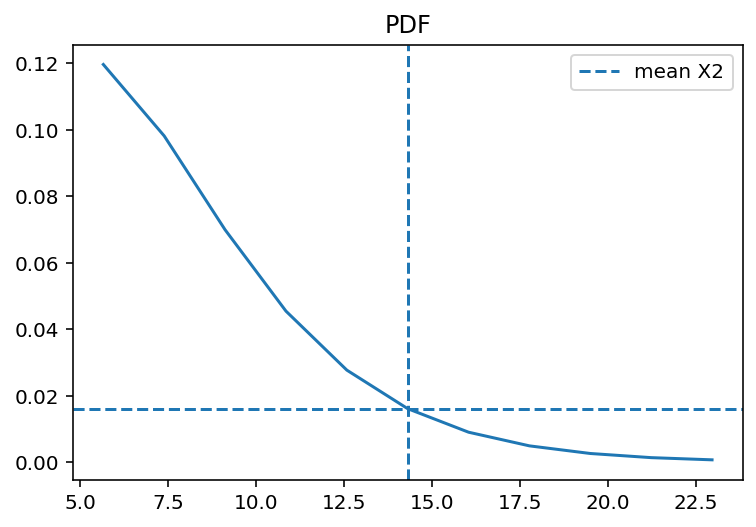

'PDF Mean: 0.01608333271831151'

In [318]:
pdf = chi2.pdf(-1*edges,deg_of_frdm)
plt.plot(-edges,pdf)
plt.axvline(-mean,linestyle='--',label='mean X2')
plt.axhline(chi2.pdf(-1*mean,deg_of_frdm),linestyle='--')
plt.title("PDF")
plt.legend()
plt.show()
F"PDF Mean: {chi2.pdf(-1*mean,deg_of_frdm)}"

In [319]:
mode = stats.mode(2*log_prob_samples[:])

cdf = chi2.cdf(-np.mean(mode[0]),deg_of_frdm)
print("pval =", 1-cdf)

cdf = chi2.cdf((-2*log_prob_samples[:].max()),deg_of_frdm)
print("pval chi2 min =", 1-cdf)

cdf = chi2.cdf(np.mean(-2*log_prob_samples[row,col]),deg_of_frdm)
print("pval =", 1-cdf)

pval = 0.02010208753875531
pval chi2 min = 0.12551446869484084
pval = 0.021196007469554412


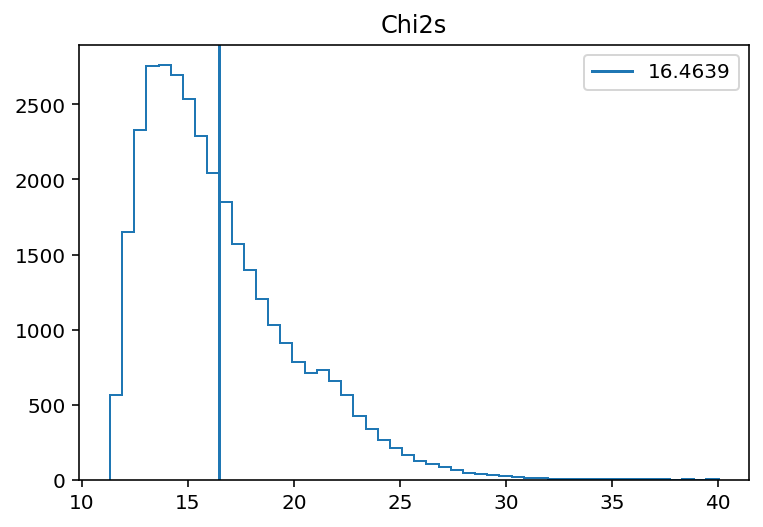

In [320]:
#plot chi2 distribution
sort_chi2 = np.sort(-2*log_prob_samples,axis=None)
plt.hist(sort_chi2[0::50],bins=50,histtype='step')
mean = np.mean(sort_chi2[0::50])
plt.axvline(mean, label=str(round(mean,4)))
plt.legend()
plt.title('Chi2s')
plt.savefig('chi2s_hist_'+fname[:-3]+'.png')

In [321]:
np.shape(samples)

(82500, 20, 5)

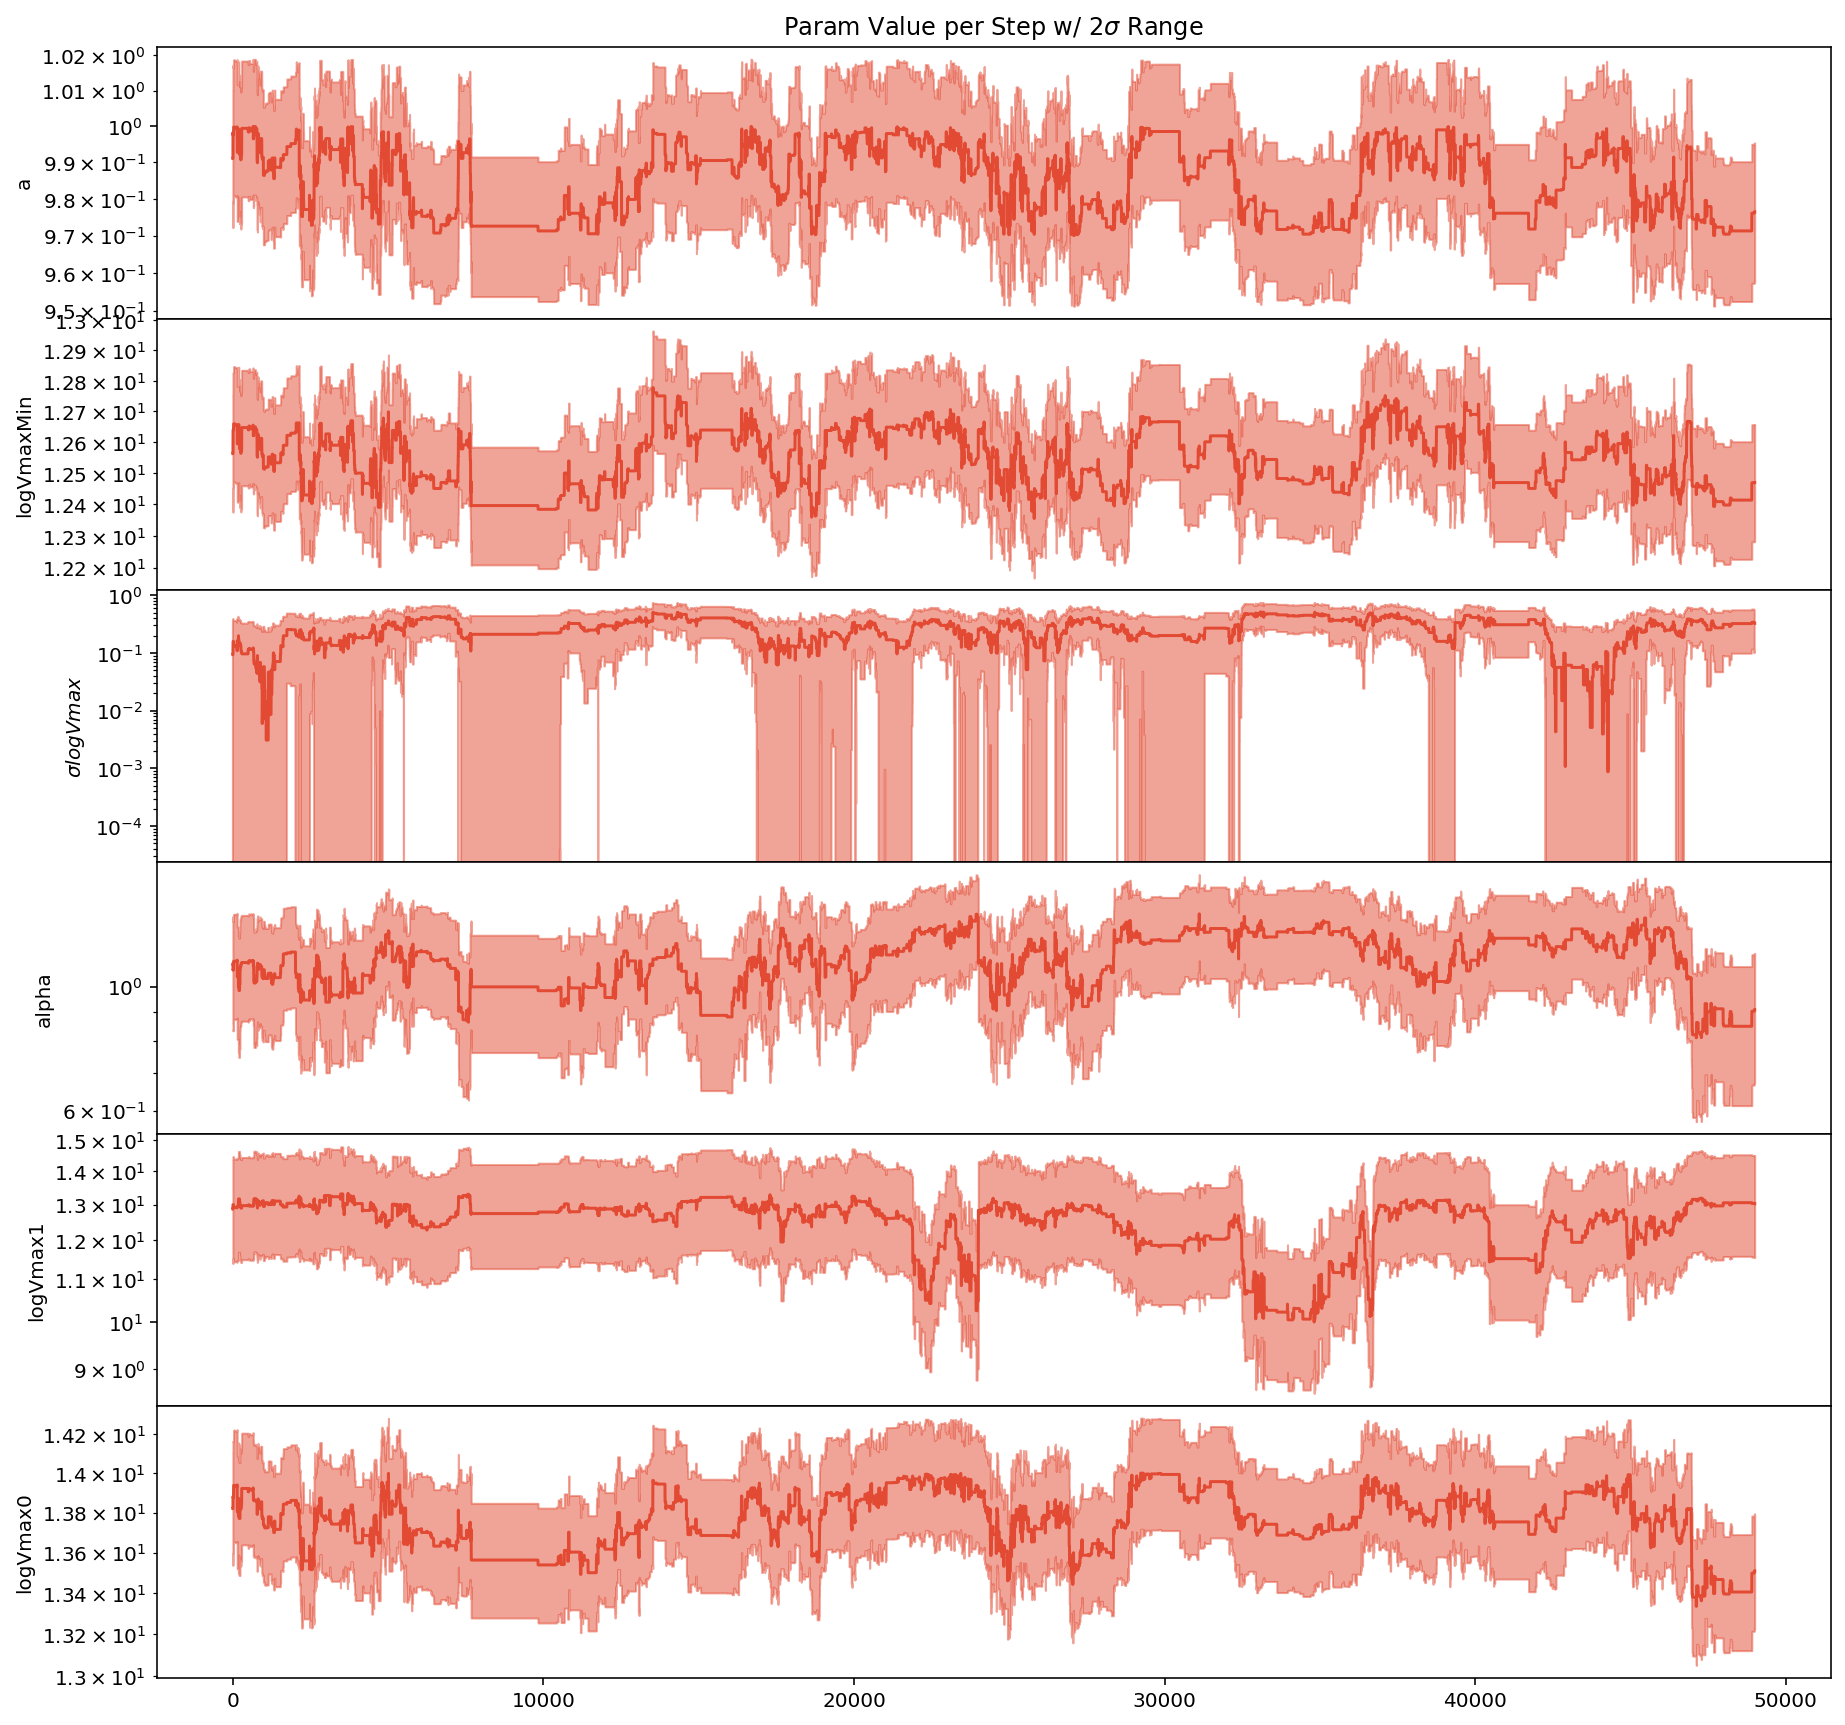

In [275]:
j = 4
r_val = 1
c = ['#e34a33']#['#fee8c8','#fdbb84','#e34a33']
steps = np.linspace(0,len(samples[:]),len(samples[:]))

fig, axs = plt.subplots(6,figsize=(15,15),gridspec_kw={'hspace': 0},sharex=True)
#fig.suptitle('First 10K vs last 10K steps for single walker')
for i in range(r_val):
    axs[0].semilogy(samples[:,i+j,0],c= c[-i])
    axs[0].fill_between(steps, samples[:,i+j,0]- 2 * samples[:,i+j,0].std(), samples[:,i+j,0]+ 2 * samples[:,i+j,0].std(),color = '#e34a33',alpha = 0.5)
    #axs[0].set(xlabel='Step')
    axs[0].set(ylabel='a')
    axs[0].set(title='Param Value per Step w/ 2$\sigma$ Range')

for i in range(r_val):
    axs[1].semilogy(samples[:,i+j,1],c= c[-i])
    axs[1].fill_between(steps, samples[:,i+j,1]- 2 * samples[:,i+j,1].std(), samples[:,i+j,1]+ 2 * samples[:,i+j,1].std(),color = '#e34a33',alpha = 0.5)
    #axs[1].set(xlabel='Step')
    axs[1].set(ylabel='logVmaxMin')

for i in range(r_val):
    axs[2].semilogy(samples[:,i+j,2],c= c[-i])
    axs[2].fill_between(steps, samples[:,i+j,2]- 2 * samples[:,i+j,2].std(), samples[:,i+j,2]+ 2 * samples[:,i+j,2].std(),color = '#e34a33',alpha = 0.5)
    #axs[2].set(xlabel='Step')
    axs[2].set(ylabel='${\sigma}logVmax$')

for i in range(r_val):
    axs[3].semilogy(samples[:,i+j,3],c= c[-i])
    axs[3].fill_between(steps, samples[:,i+j,3]- 2 * samples[:,i+j,3].std(), samples[:,i+j,3]+ 2 * samples[:,i+j,3].std(),color = '#e34a33',alpha = 0.5)
    #axs[3].set(xlabel='Step')
    axs[3].set(ylabel='alpha')

for i in range(r_val):
    axs[4].semilogy(samples[:,i+j,4],c= c[-i])
    axs[4].fill_between(steps, samples[:,i+j,4]- 2 * samples[:,i+j,4].std(), samples[:,i+j,4]+ 2 * samples[:,i+j,4].std(),color = '#e34a33',alpha = 0.5)
    axs[4].set(xlabel='Steps')
    axs[4].set(ylabel='logVmax1')
    
for i in range(r_val):
    axs[5].semilogy(samples[:,i+j,5],c= c[-i])
    axs[5].fill_between(steps, samples[:,i+j,5]- 2 * samples[:,i+j,5].std(), samples[:,i+j,5]+ 2 * samples[:,i+j,5].std(),color = '#e34a33',alpha = 0.5)
    #axs[0].set(xlabel='Step')
    axs[5].set(ylabel='logVmax0')

plt.savefig('comp_param_v_step_'+fname[:-3]+'.png')

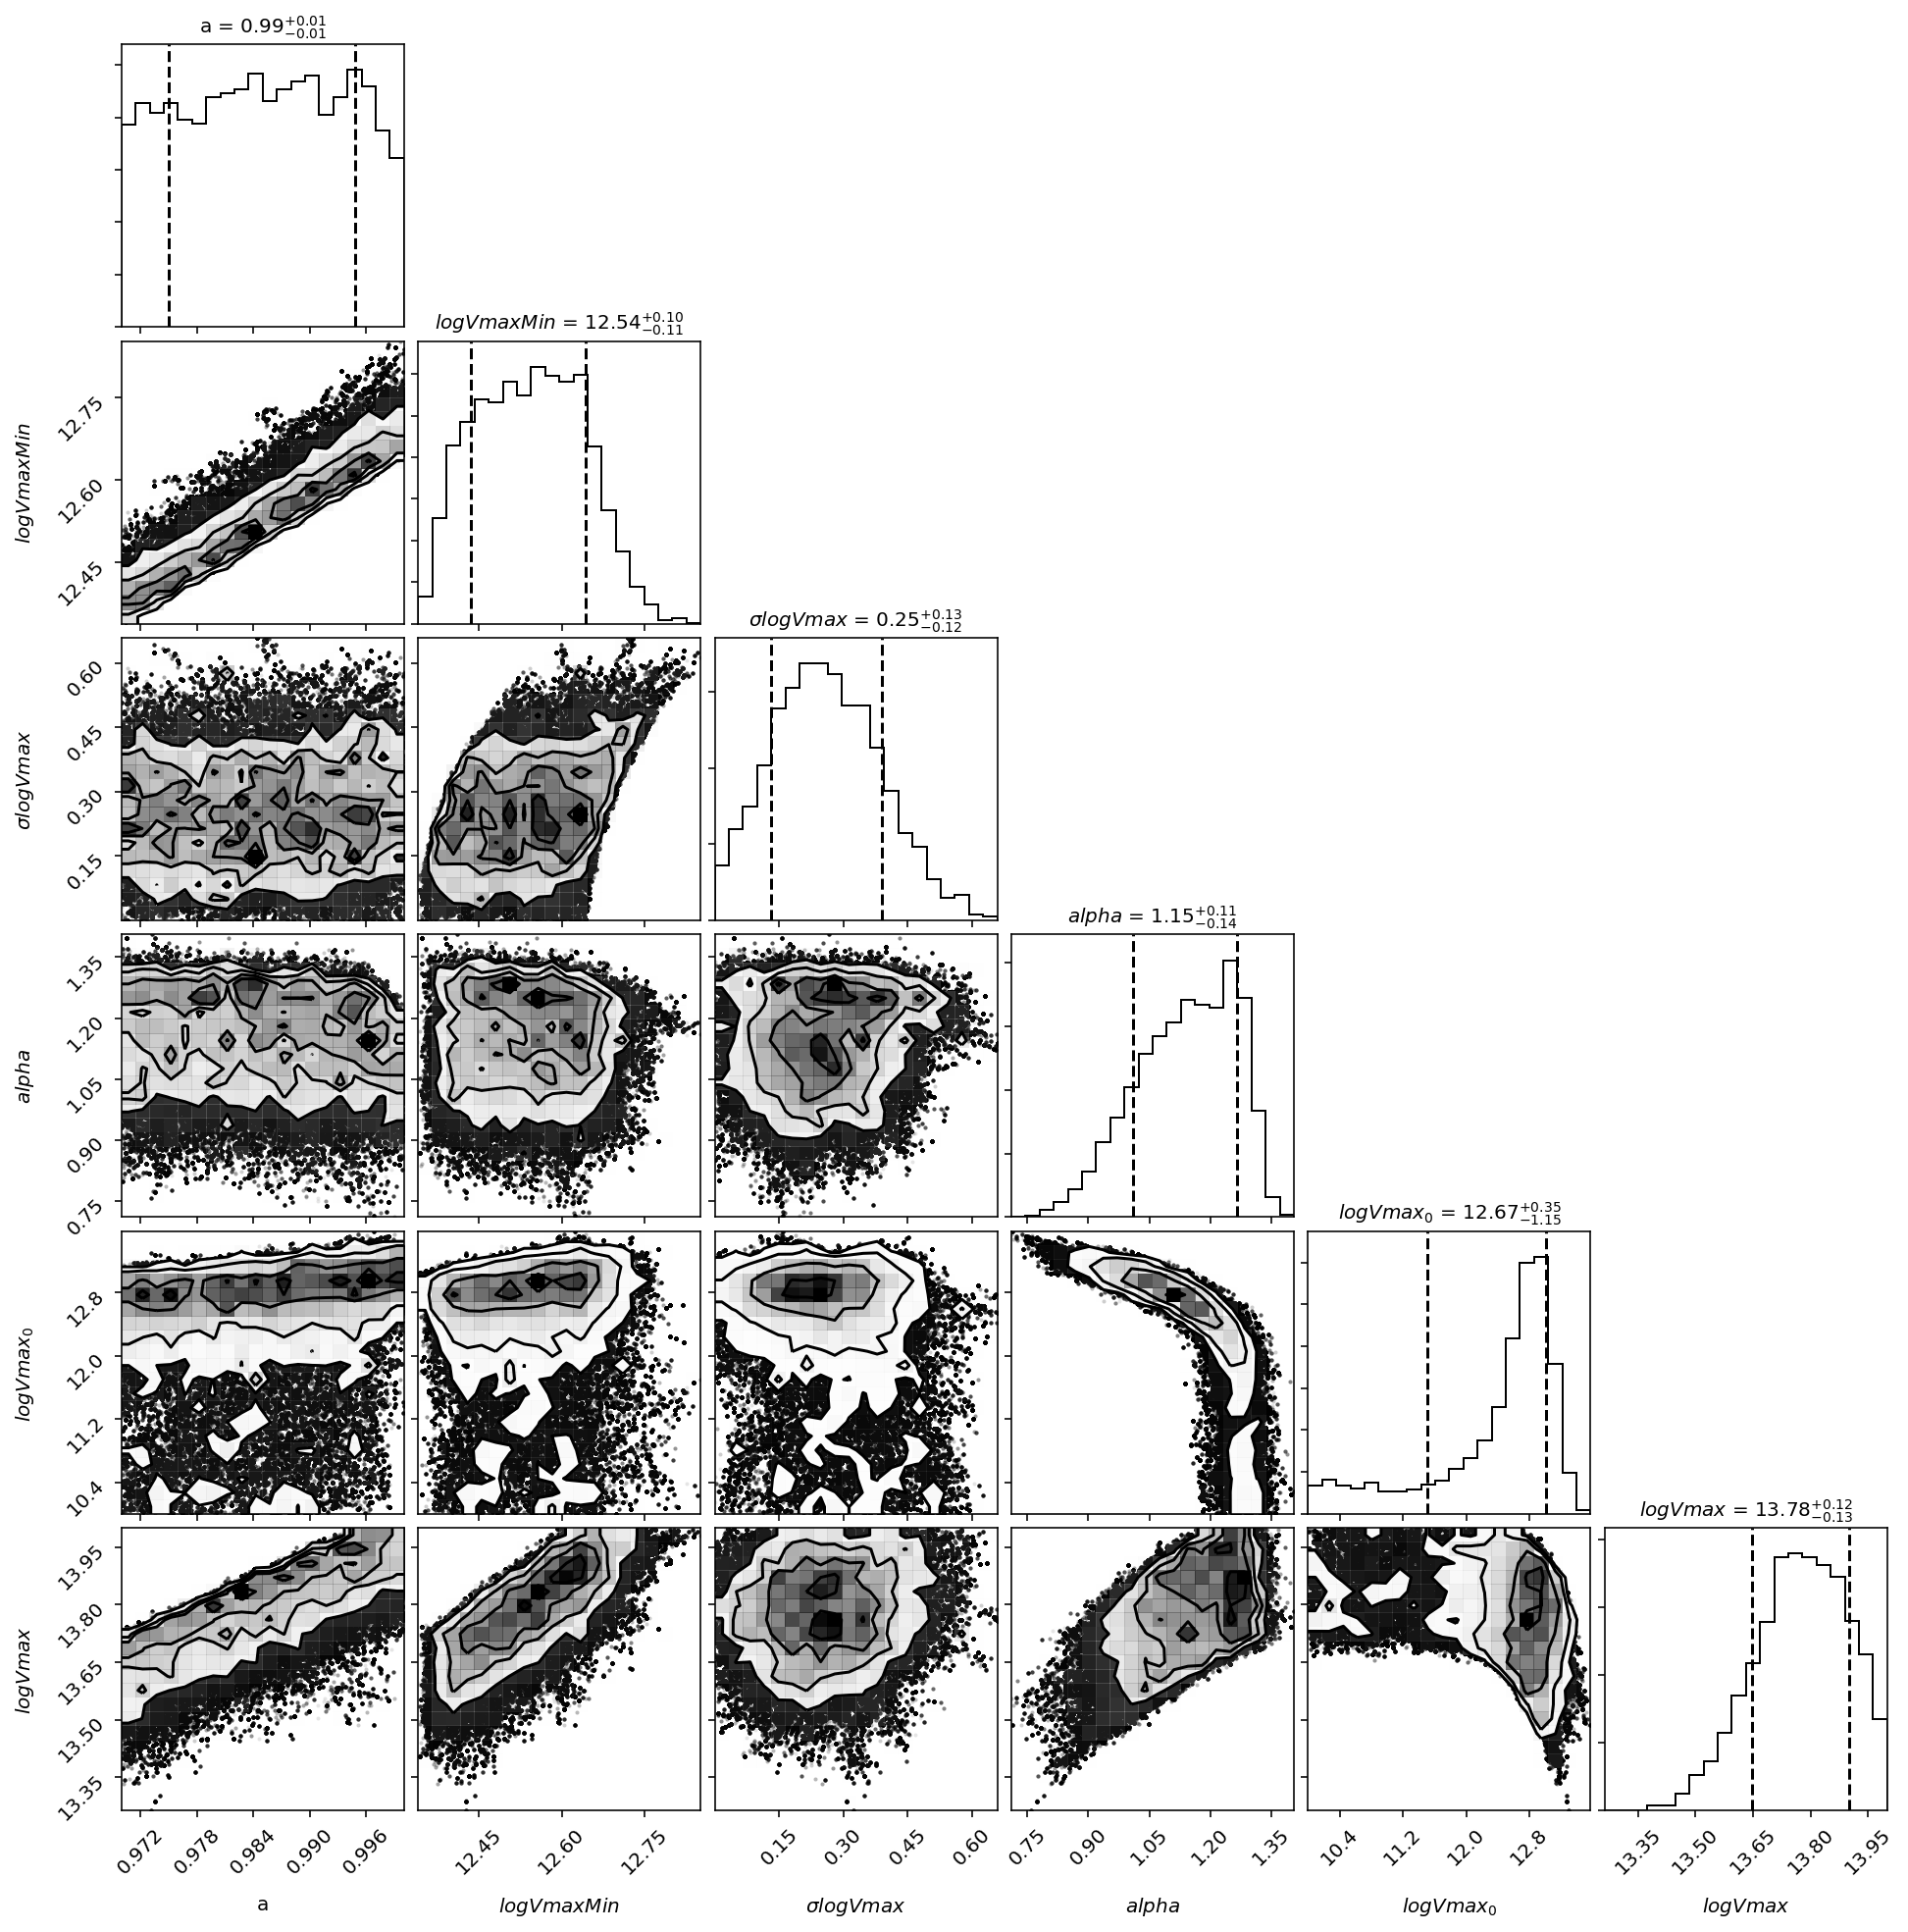

In [411]:
ndim=6
fig = corner.corner(samples.reshape((-1,ndim)),
        labels=["a","$logVmaxMin$", "${\sigma}logVmax$", "$alpha$", "$logVmax_0$", "$logVmax$"],
        show_titles=True,title_kwargs={"fontsize": 10},quantiles=(0.16, 0.84))#, levels=(1-np.exp(-0.5),))
plt.savefig('corner_'+fname[:-3]+'.png')

In [190]:
a_vals = samples.reshape(74000*35,6)[:,0]
cut1 = np.where(0.66<=a_vals)
cut2 = np.where(0.97>a_vals[cut1])

ValueError: cannot reshape array of size 10290000 into shape (2590000,6)

In [ ]:
chi2 = -2*log_prob_samples.reshape(74000*35)[cut1][cut2]

In [ ]:
plt.scatter(a_vals[cut1][cut2][::intvl],chi2[::intvl])

In [ ]:
plt.hist(a_vals[cut1][cut2],histtype='step')
plt.hist(chi2,histtype='step')

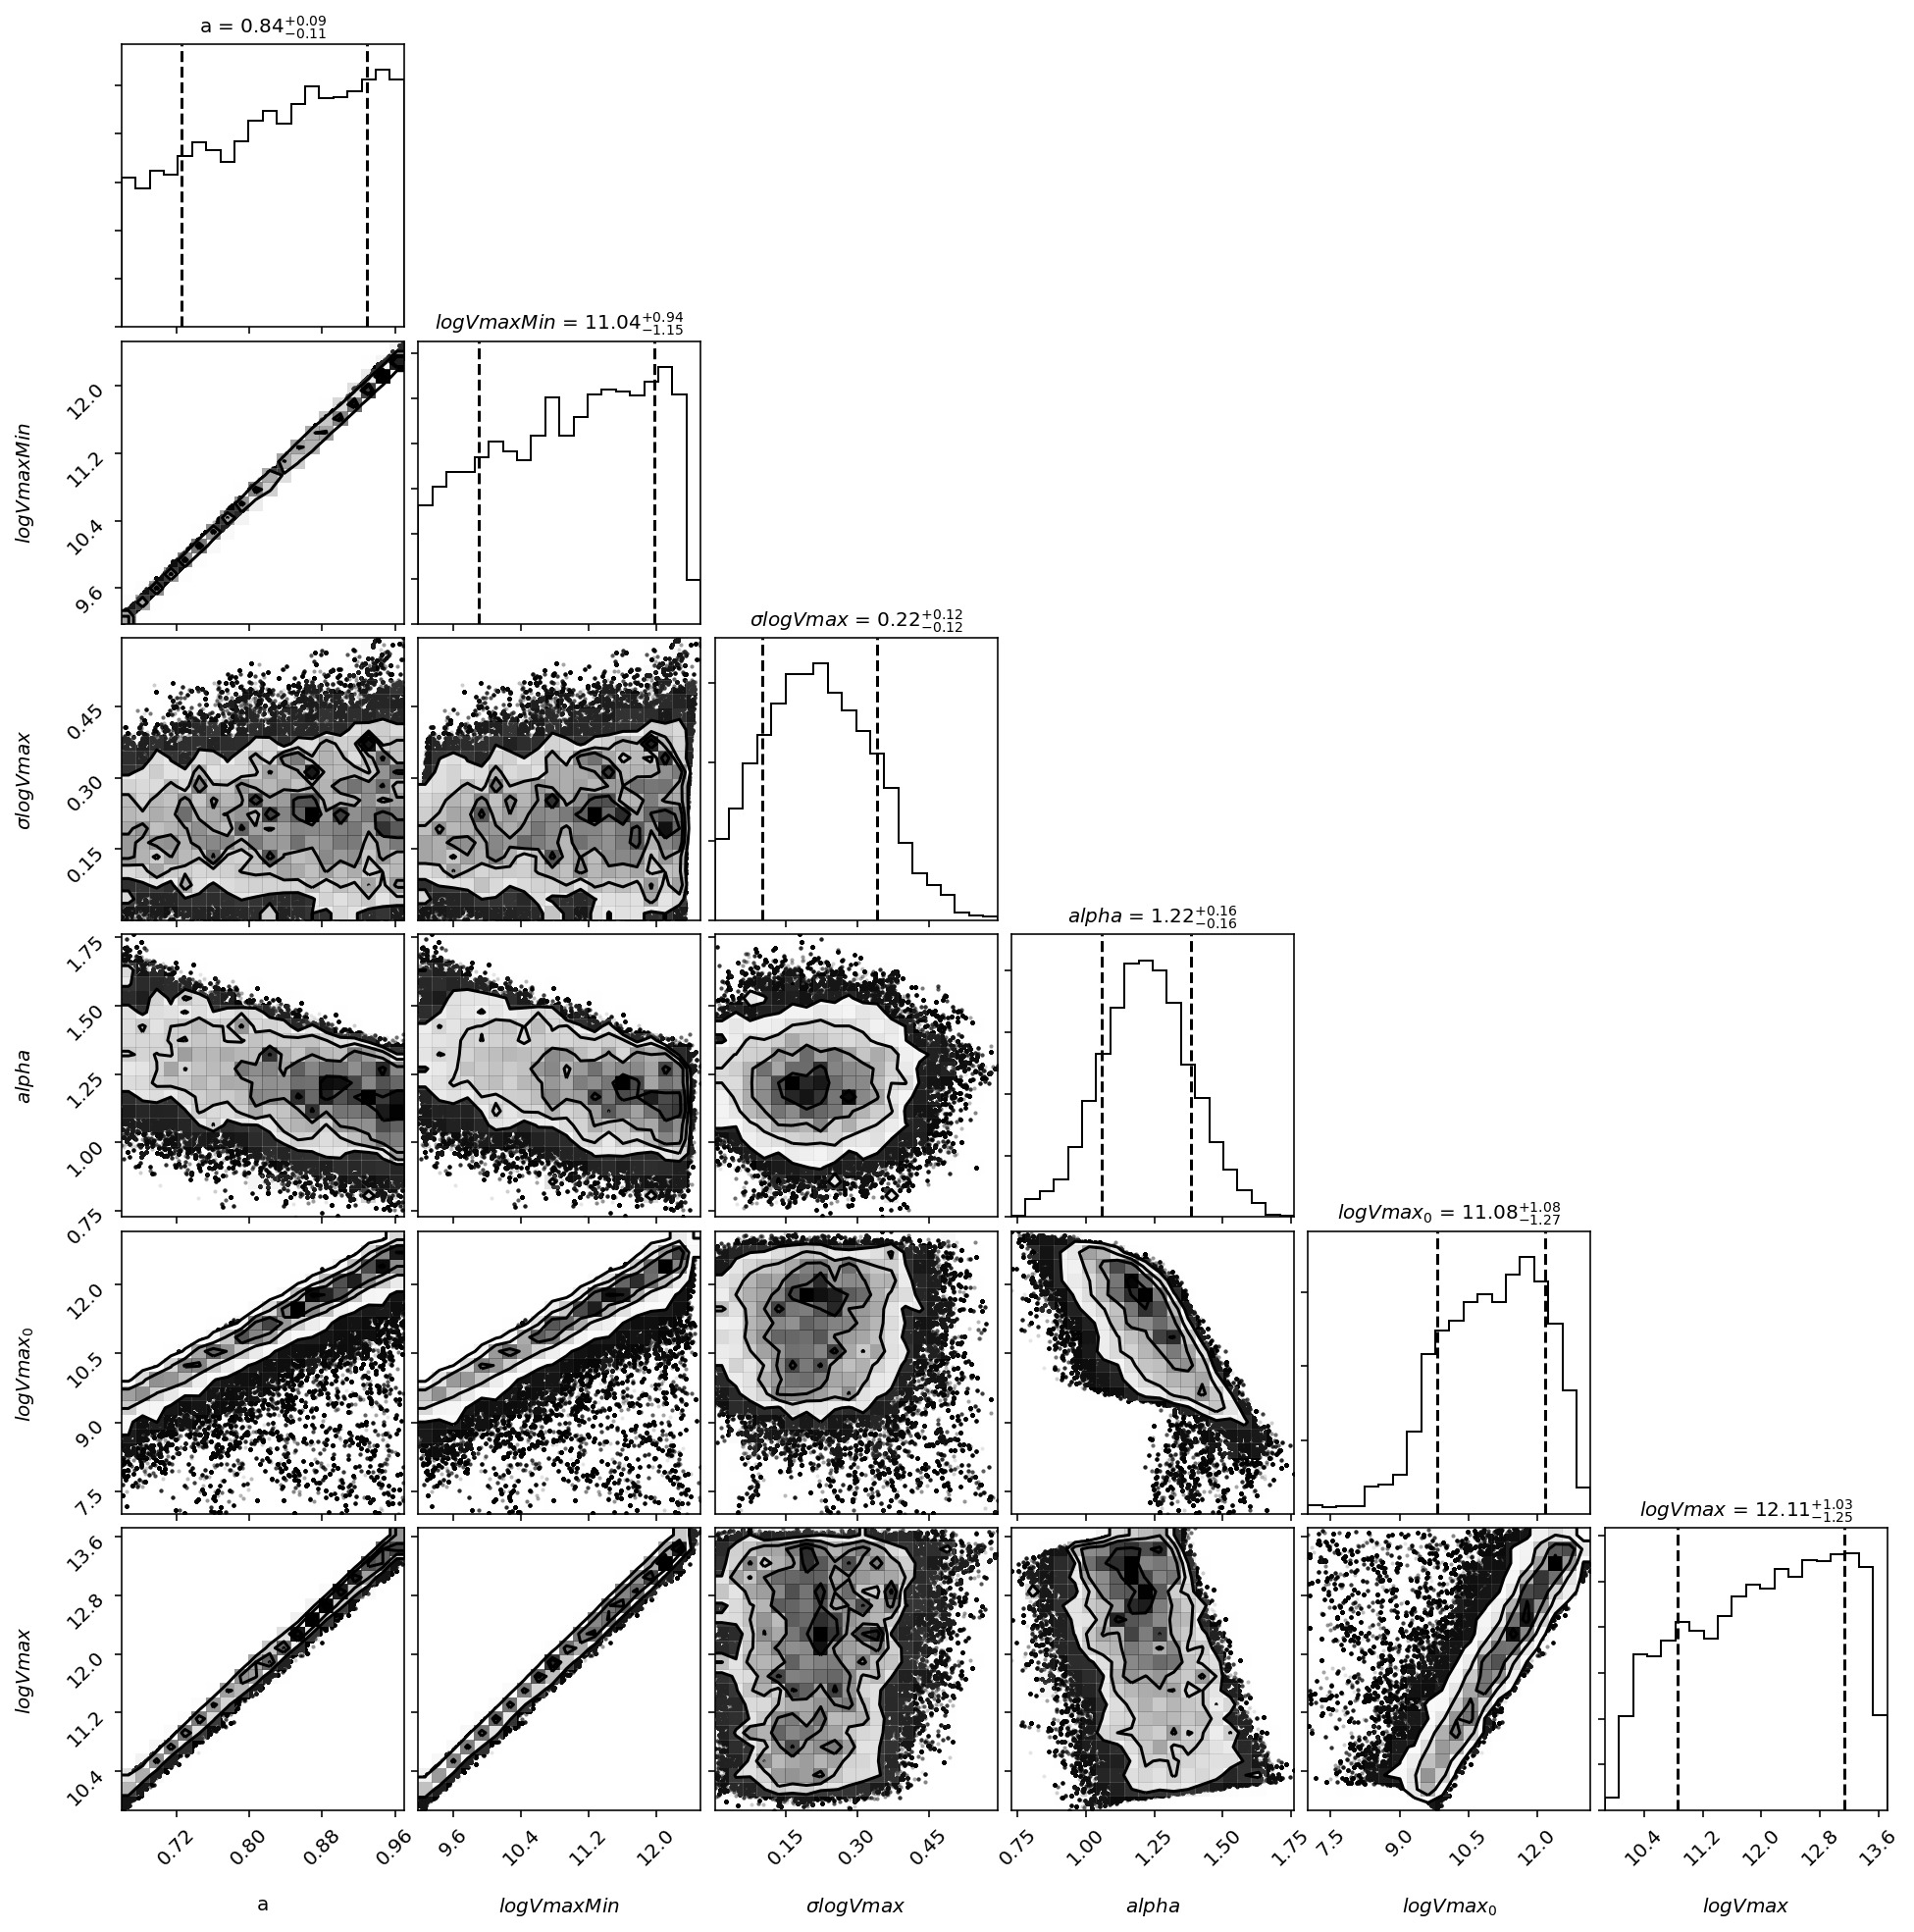

In [68]:
ndim=6
fig = corner.corner(samples.reshape(74000*35,6)[cut1][cut2],
        labels=["a","$logVmaxMin$", "${\sigma}logVmax$", "$alpha$", "$logVmax_0$", "$logVmax$"],
        show_titles=True,title_kwargs={"fontsize": 10},quantiles=(0.16, 0.84))#, levels=(1-np.exp(-0.5),))

In [69]:
cut_min = chi2 == np.min(-2*log_prob_samples.reshape(74000*35)[cut1][cut2])
len(chi2)


1662675

In [70]:
samples.reshape((74000*35,6))[cut1][cut2][cut_min]

array([[ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       ...,
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ],
       [ 0.85181899, 11.19911999,  0.32678546,  1.03760733, 11.68167738,
        12.1467287 ]])

In [444]:
np.shape(cut_min)

(1955578,)